# Perkenalan

Objective: Bank A sedang merencanakan merger dengan Bank B untuk keperluan modal kerja dan kerja sama jangka panjang dan ingin membuat kartu kredit tipe baru sehingga diperlukan data-data nasabah pada Bank A untuk dievaluasi lebih lanjut. Tim Data Science di beri tugas untuk memeriksa apa yang bisa di explorasi. Kita dari Tim data science diminta untuk menghitung prediksi memprediksi pengguna kartu kredit dan nantinya akan menjadi pedoman yang akan digunakan kedepannya.

# Query SQL

In [129]:
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id = "project-403108" #GUNAKAN GCP PROJECT-ID KALIAN MASING-MASING
client = bigquery.Client(project=project_id)

Authenticated


# Import Libraries

In [130]:
pip install -U feature-engine

In [131]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from mlxtend.plotting import plot_decision_regions
import pickle, joblib
import json
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Data Loading

In [132]:
#pilih kolom dan ubah data type
df = client.query('''

SELECT
  limit_balance,
  CAST(sex AS INT64) AS sex,
  CAST(education_level AS INT64) AS education_level,
  CAST(marital_status AS INT64) AS marital_status,
  age,
  pay_0,
  pay_2,
  pay_3,
  pay_4,
  CAST(pay_5 AS FLOAT64) AS pay_5,
  CAST(pay_6 AS FLOAT64) AS pay_6,
  bill_amt_1,
  bill_amt_2,
  bill_amt_3,
  bill_amt_4,
  bill_amt_5,
  bill_amt_6,
  pay_amt_1,
  pay_amt_2,
  pay_amt_3,
  pay_amt_4,
  pay_amt_5,
  pay_amt_6,
  CAST(default_payment_next_month AS INT64) AS default_payment_next_month
FROM
  `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT
  49850
''').to_dataframe()

In [133]:
# Menyiman DataFrame ke dalam file CSV
df.to_csv('P1G5_Set_1_david_tjoea.csv', index=False)

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   Int64  
 2   education_level             2965 non-null   Int64  
 3   marital_status              2965 non-null   Int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

In [135]:
#mengecek 10 data teratas
df.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [136]:
#mengecek 10 data terbawah
df.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


In [137]:
#mengecek jumlah baris dan kolom
df.shape

(2965, 24)

# Exploratory Data Analysis (EDA)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


<Axes: xlabel='default_payment_next_month', ylabel='Count'>

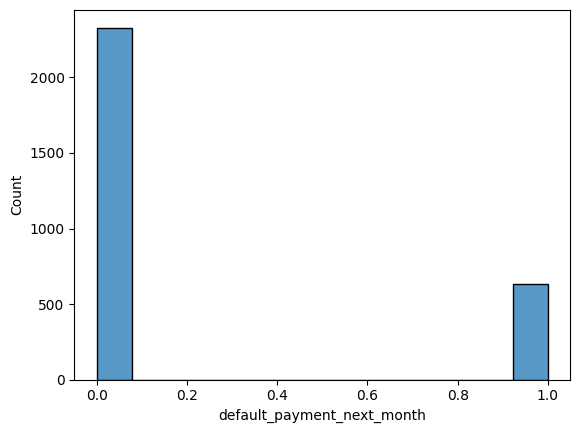

In [138]:
#menampiklan histogram default payment
sns.histplot(df.default_payment_next_month)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


<Axes: xlabel='sex', ylabel='Count'>

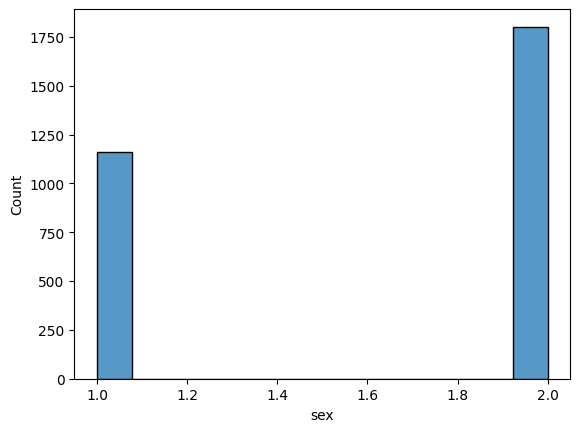

In [139]:
#menampiklan histogram sex
sns.histplot(df.sex)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


<Axes: xlabel='education_level', ylabel='Count'>

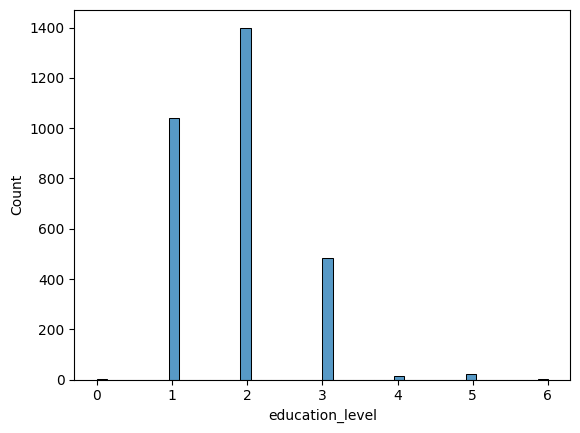

In [140]:
#menampiklan histogram
sns.histplot(df.education_level)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


<Axes: xlabel='marital_status', ylabel='Count'>

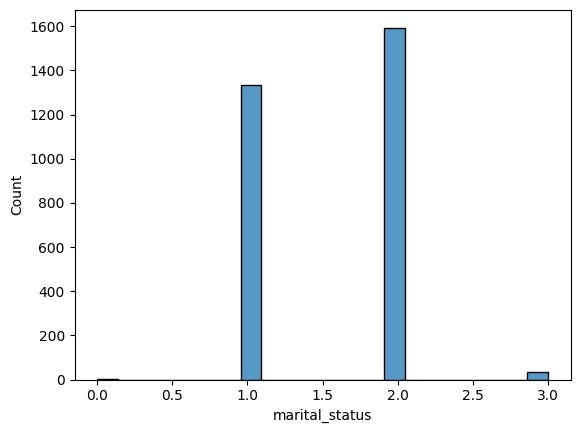

In [141]:
#menampiklan histogram
sns.histplot(df.marital_status)

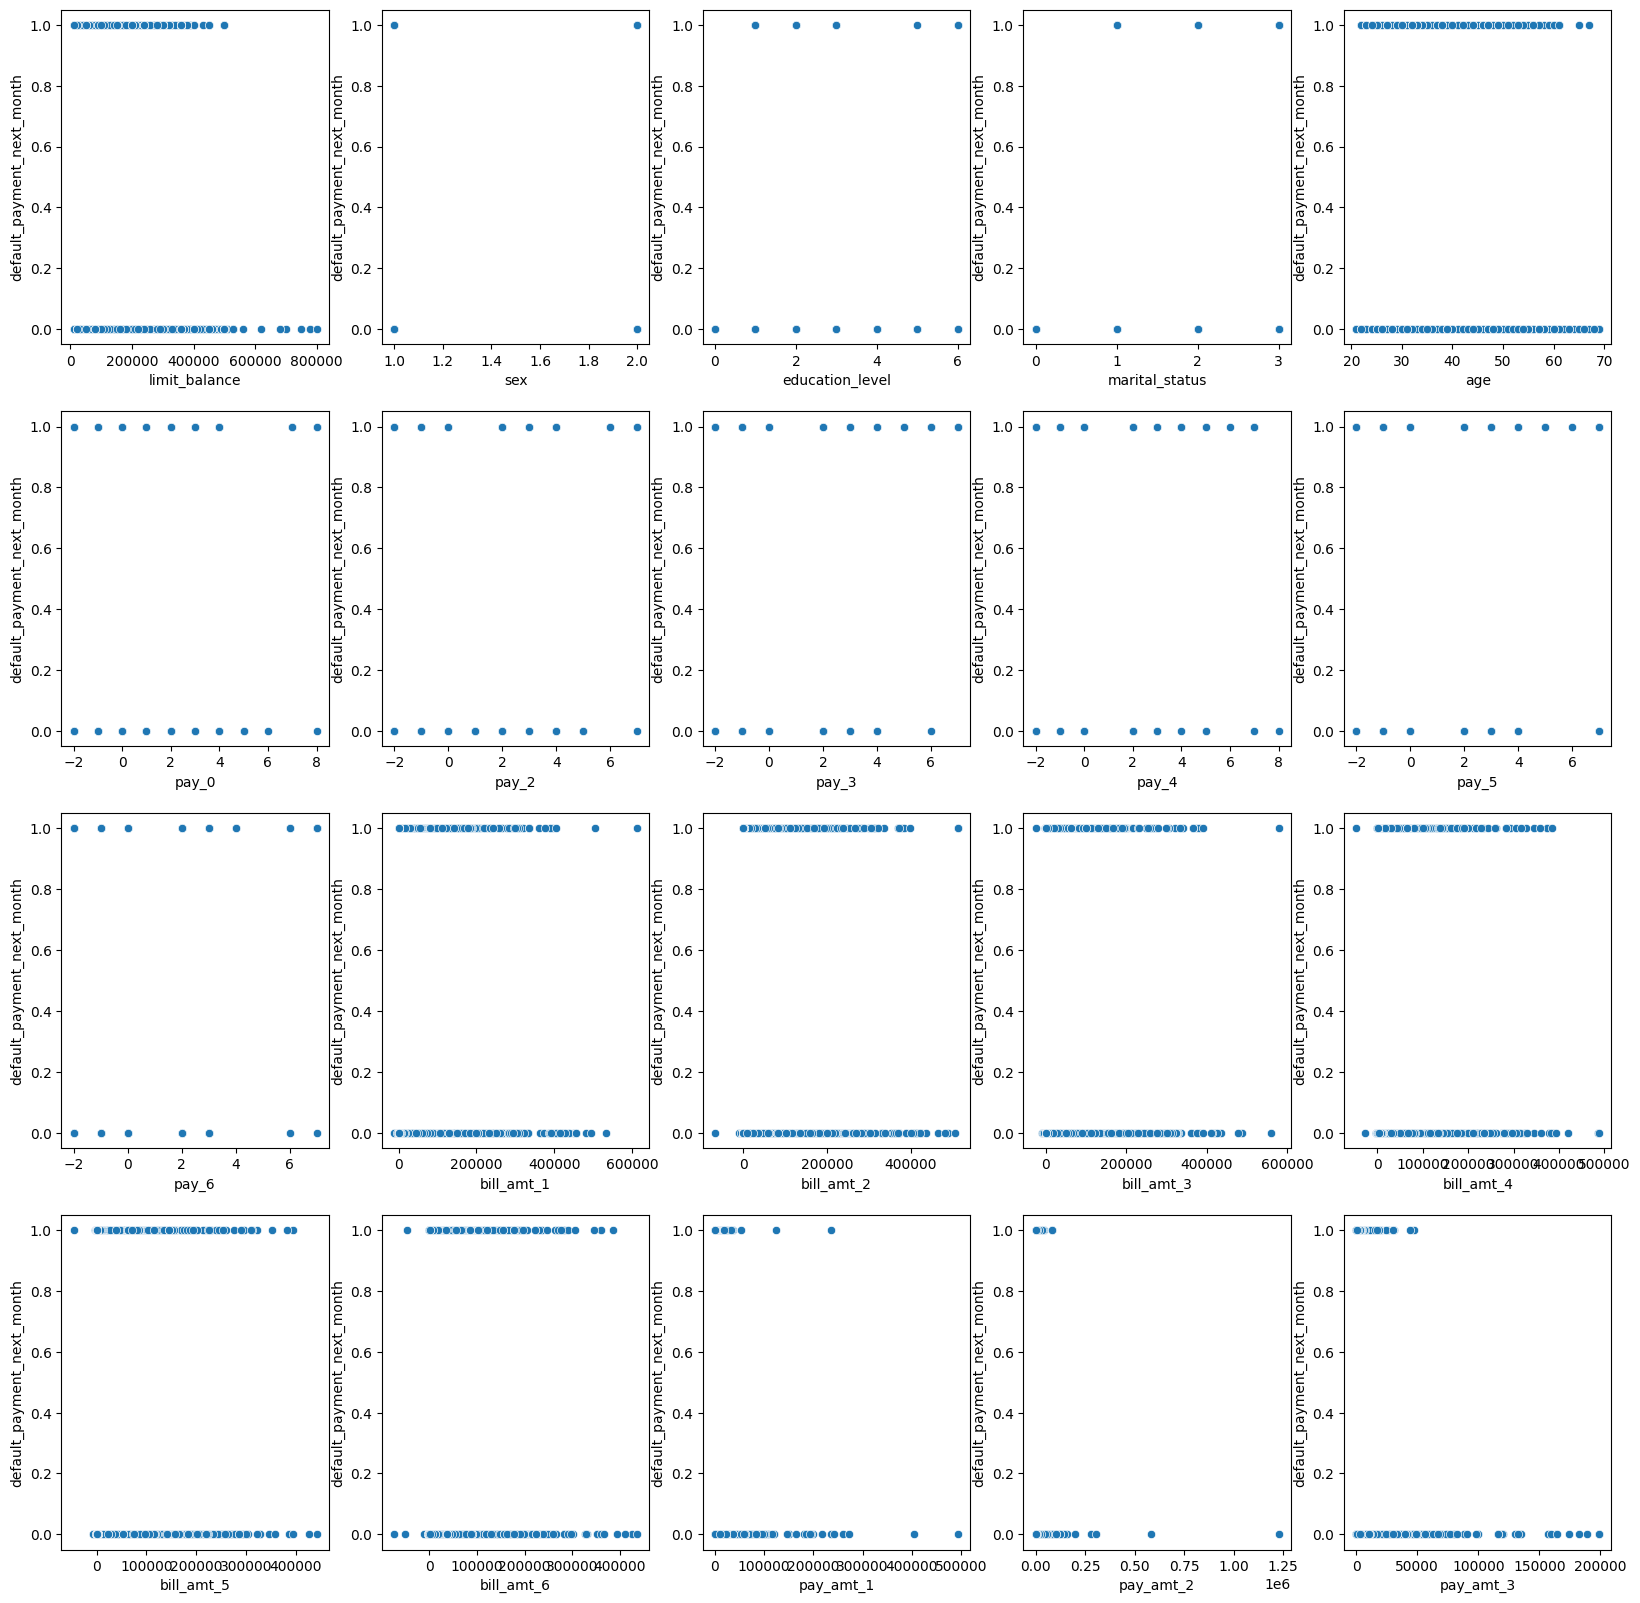

In [142]:
#split data x dan y
#define x dan y

x = df.drop(['default_payment_next_month'],axis=1)
y = df[['default_payment_next_month']]
#menampiklan plot
fig = plt.figure(figsize=(20, 20))
cols = x.columns.tolist()
num_rows = 4
num_cols = 5

for index in range(1, num_rows*num_cols + 1):
  fig.add_subplot(num_rows, num_cols, index)
  sns.scatterplot(data=df, x=cols[index-1], y='default_payment_next_month')
plt.show()

# Feature Engineering

In [143]:
#split data x dan y
#define x dan y

x = df.drop(['default_payment_next_month'],axis=1)
y = df[['default_payment_next_month']]
y

,default_payment_next_month
0,1
1,0
2,1
3,0
4,0
...,...
2960,0
2961,1
2962,1
2963,0


Memisahkan data keseluruhan menjadi data x dan y.

a. Data Y yang dipakai adalah Default payment Next month

b. Data X yaitu limit_balance,sex, education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6.

In [144]:
#splitting train dan test data
#randomstate supaya ketika data di run berulang ulang tidak menjadi acak
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=21)

print('Train Size : ', x_train.shape)
print('Test Size  : ', x_test.shape)
x_train

Train Size :  (2372, 23)
Test Size  :  (593, 23)


,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
118,300000.0,1,1,2,25.0,0.0,0.0,0.0,0.0,0.0,...,31180.0,19507.0,18169.0,18533.0,4103.0,1427.0,600.0,1200.0,2500.0,18000.0
794,160000.0,2,2,1,35.0,0.0,0.0,0.0,0.0,0.0,...,7035.0,4596.0,4635.0,2744.0,2000.0,1000.0,500.0,1000.0,1000.0,2000.0
1493,130000.0,2,3,1,44.0,-1.0,2.0,2.0,-1.0,0.0,...,0.0,632.0,316.0,316.0,0.0,0.0,948.0,0.0,316.0,316.0
647,30000.0,2,2,1,27.0,0.0,0.0,0.0,0.0,0.0,...,22844.0,22101.0,19535.0,19580.0,1712.0,1400.0,442.0,391.0,500.0,0.0
2469,500000.0,1,1,2,43.0,0.0,0.0,0.0,-1.0,-1.0,...,0.0,3887.0,0.0,7413.0,22650.0,0.0,3887.0,0.0,7413.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,340000.0,2,2,2,27.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,4794.0,7819.0,332.0,16516.0,9318.0,5343.0,7819.0,332.0,16516.0,5000.0
48,310000.0,1,1,2,45.0,0.0,0.0,0.0,0.0,0.0,...,283847.0,290135.0,293350.0,300623.0,10010.0,11500.0,11015.0,11000.0,12000.0,23035.0
772,120000.0,2,2,2,27.0,0.0,0.0,0.0,0.0,0.0,...,9624.0,20129.0,10388.0,13316.0,1137.0,1514.0,1069.0,278.0,3000.0,0.0
1848,60000.0,2,2,1,31.0,0.0,0.0,2.0,2.0,2.0,...,39676.0,42407.0,41428.0,45576.0,4000.0,0.0,3700.0,0.0,5000.0,2000.0


Jumlah data pada x train sebanyak 2372 data dana x test sebanyak 593 data

## Define Feature Numeric and Categories

Memisahkan kolom numerik dan kategorik menjadi 2 bagian

In [145]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   limit_balance    2965 non-null   float64
 1   sex              2965 non-null   Int64  
 2   education_level  2965 non-null   Int64  
 3   marital_status   2965 non-null   Int64  
 4   age              2965 non-null   float64
 5   pay_0            2965 non-null   float64
 6   pay_2            2965 non-null   float64
 7   pay_3            2965 non-null   float64
 8   pay_4            2965 non-null   float64
 9   pay_5            2965 non-null   float64
 10  pay_6            2965 non-null   float64
 11  bill_amt_1       2965 non-null   float64
 12  bill_amt_2       2965 non-null   float64
 13  bill_amt_3       2965 non-null   float64
 14  bill_amt_4       2965 non-null   float64
 15  bill_amt_5       2965 non-null   float64
 16  bill_amt_6       2965 non-null   float64
 17  pay_amt_1     

 Tidak data Kategorik yang dengan data type object ataupun datetime.

In [146]:
num_columns = x_train.select_dtypes(include=['float64','int64']).columns.tolist()
cat_columns = x_train.select_dtypes(include=['object']).columns.tolist()

print('Num Columns : ', num_columns)
print('Cat Columns : ', cat_columns)

Num Columns :  ['limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']
Cat Columns :  []


## Handling Cardinality

Handling Cardinality hanya dilakukan pada data dengan type kategorik yang nominal

Tidak ada data kategorik sehingga tidak perlu di handling

## Handling Outlier

Handling Oulier hanya pada data numerik yaitu float64 an int64

In [148]:
# Calculate skewness for each column
skewness = df.skew()

# Print skewness values
print("Skewness for each column:")
print(skewness)

Skewness for each column:
limit_balance                  1.000442
sex                           -0.441625
education_level                0.899875
marital_status                -0.020106
age                            0.772887
pay_0                          0.926790
pay_2                          0.861762
pay_3                          0.931460
pay_4                          1.101504
pay_5                          1.060173
pay_6                          0.978760
bill_amt_1                     2.484598
bill_amt_2                     2.458349
bill_amt_3                     2.569937
bill_amt_4                     2.448175
bill_amt_5                     2.400343
bill_amt_6                     2.432406
pay_amt_1                     11.877647
pay_amt_2                     29.404261
pay_amt_3                      8.044639
pay_amt_4                      8.451541
pay_amt_5                     11.468890
pay_amt_6                      9.760184
default_payment_next_month     1.394199
dtype: float64

The normal distribution will have a skewness ranging from -0.5 to 0.5. Any distribution outside this range is considered a skewed distribution.

From the result above, we can conclude :
1. Column limit_balance: extreme skewed distiribution.
2. Column age: skewed distiribution.
3. COlumn bill_amt_1: extreme skewed distiribution.
4. COlumn bill_amt_2: extreme skewed distiribution.
5. COlumn bill_amt_3: extreme skewed distiribution.
6. COlumn bill_amt_4: extreme skewed distiribution.
7. COlumn bill_amt_5: extreme skewed distiribution.
8. COlumn bill_amt_6: extreme skewed distiribution.
9. COlumn pay_0: extreme skewed distiribution.
10. COlumn pay_2: extreme skewed distiribution.
11. COlumn pay_3: extreme skewed distiribution.
12. COlumn pay_4: extreme skewed distiribution.
13. COlumn pay_5: extreme skewed distiribution.
14. COlumn pay_6: extreme skewed distiribution.
15. COlumn pay_amt_1: extreme skewed distiribution.
16. COlumn pay_amt_2: extreme skewed distiribution.
17. COlumn pay_amt_3: extreme skewed distiribution.
18. COlumn pay_amt_4: extreme skewed distiribution.
19. COlumn pay_amt_5: extreme skewed distiribution.
20. COlumn pay_amt_6: extreme skewed distiribution.
21. COlumn marital status: normal  distiribution.
22. COlumn education level:  skewed distiribution.
23. COlumn sex: skewed distiribution.

### Detect the outlier

In [149]:
# Function to create histogram and boxplot.
# This functions takes a dataframe (df) and the variable of interest as arguments.

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

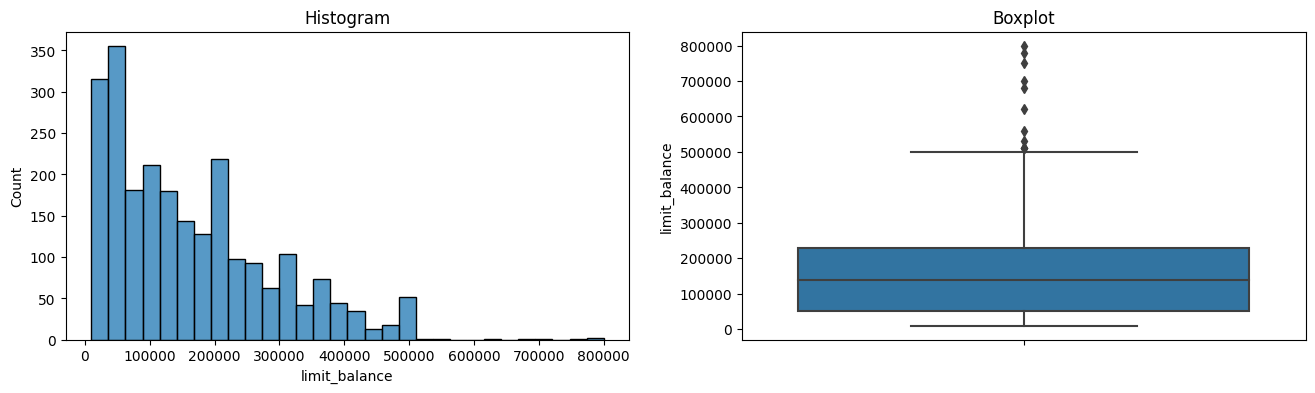

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


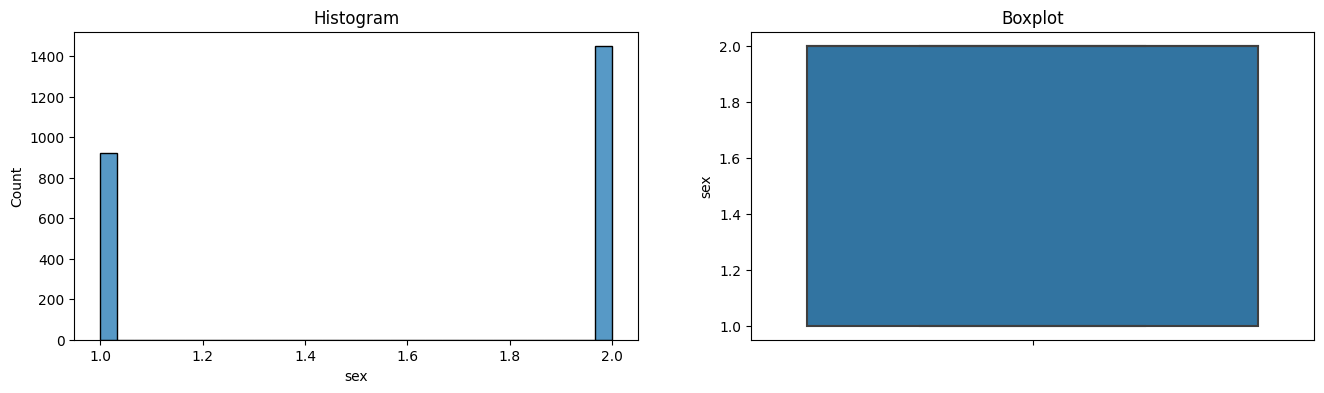

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


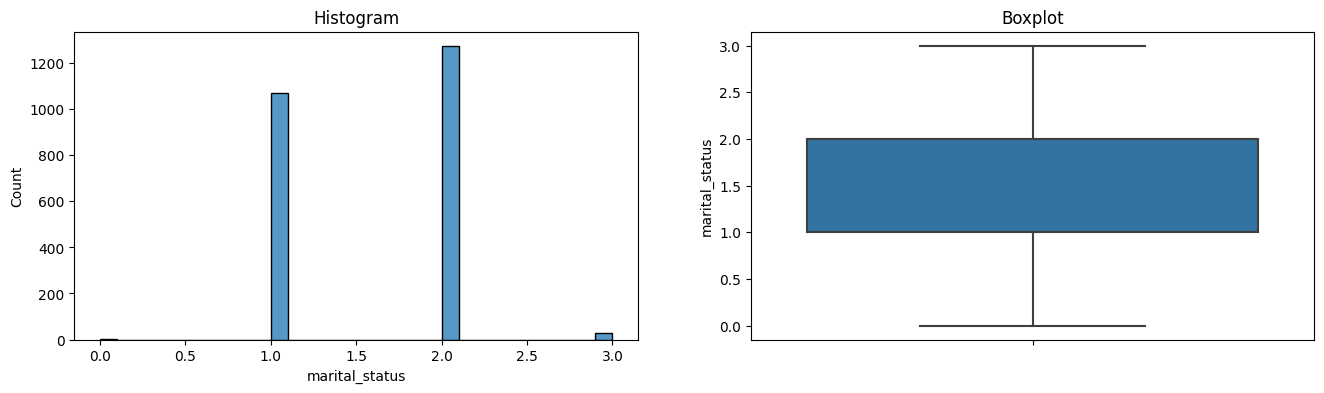

KeyError: ignored

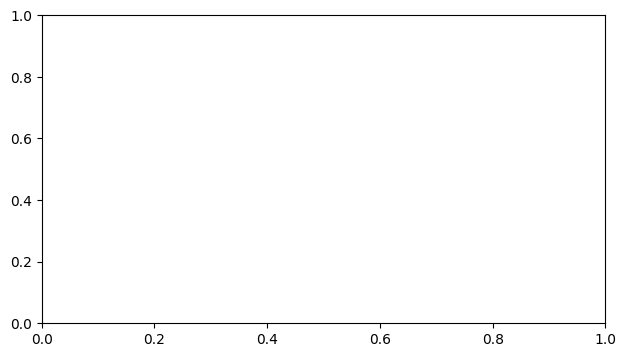

In [247]:
# list kolom untuk menampilkan diagnostic plot
columns_to_plot = ['limit_balance','sex','marital_status','educationl_level','pay_0','sex','pay_0','pay_2','pay_3','pay_5','pay_6'
'bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6','pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4',
'pay_amt_5','pay_amt_6']

# Apply diagnostic_plots function to each column
for column in columns_to_plot:
    diagnostic_plots(x_train, column)



Dari hasil yang ditampilkan :
1. Column limit_balance: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.
2. Column age: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.
3. COlumn bill_amt_1: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.
4. COlumn bill_amt_2: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.
5. COlumn bill_amt_3: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.
6. COlumn bill_amt_4: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.
7. COlumn bill_amt_5: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.
8. COlumn bill_amt_6: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.
9. COlumn pay_amt_1: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.
10. COlumn pay_amt_2: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.
11. COlumn pay_amt_3:dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.extreme skewed distiribution.
12. COlumn pay_amt_4: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.
13. COlumn pay_amt_5: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.
14. COlumn pay_amt_6: dari grafik dapat dilihat terdapat outlier **pada satu sisi** feature distance, sehingga **perlu di handling outlier** terlebih dahulu.

### Normal Distribution

Tidak ada kolom berdistribusi normal, sehingga tidak perlu di handling.

### Skewed Distribution

In [151]:
# Function to find upper and lower boundaries for skewed distributed variables
# Let's calculate the boundaries outside which sit the outliers for skewed distributions
# Distance passed as an argument, gives us the option to estimate 1.5 times or 3 times the IQR to calculate the boundaries.

def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [152]:
# Identify outliers in `limit_balance` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'limit_balance', 3)
upper_boundary_distance, lower_boundary_distance

(770000.0, -490000.0)

In [153]:
# Lets look at the number and percentage of limit balance

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 770.000   : {}'.format(len(x_train[x_train['limit_balance'] > upper_boundary_distance])))
print('')
print('% distance more than 770.000 : {}'.format(len(x_train[x_train['limit_balance'] > upper_boundary_distance])/len(x_train) * 100))

Total distance : 2372
Distance more than 770.000   : 2

% distance more than 770.000 : 0.08431703204047217


In [154]:
# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['limit_balance'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

distance - Before Capping


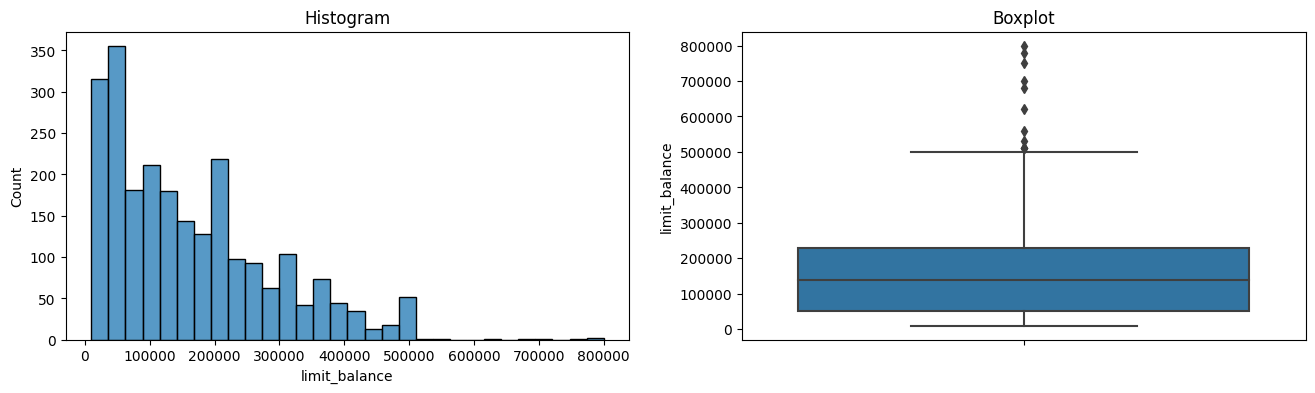


distance - After Capping


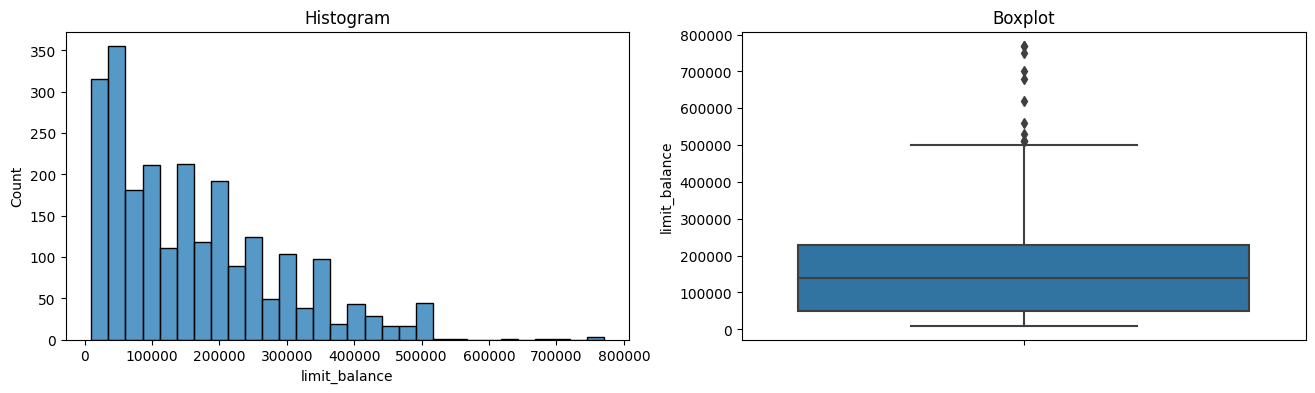

In [155]:
# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'limit_balance')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'limit_balance')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [156]:
# Identify outliers in `age` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'age', 3)
upper_boundary_distance, lower_boundary_distance

(80.0, -11.0)

Total distance : 2372
Distance more than 80   : 0

% distance more than 80: 0.0
distance - Before Capping


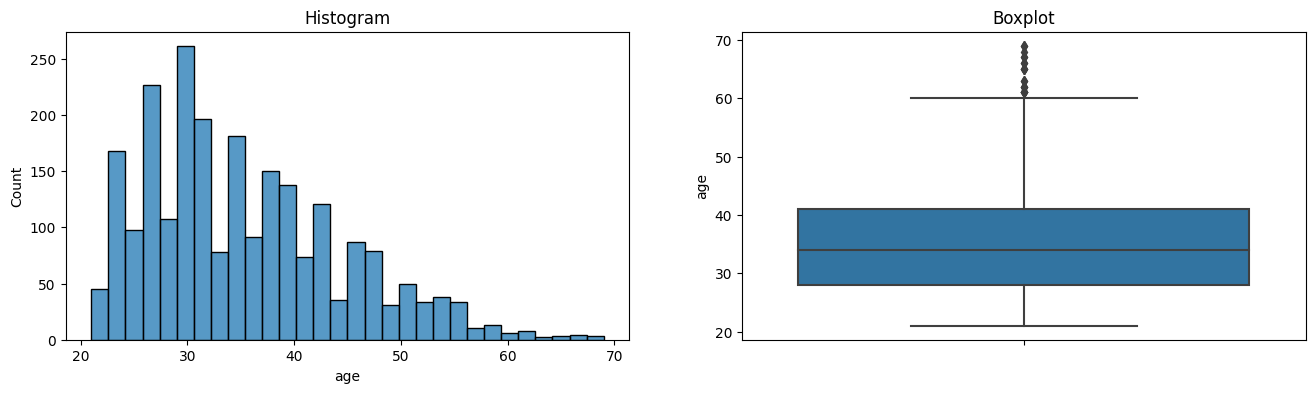


distance - After Capping


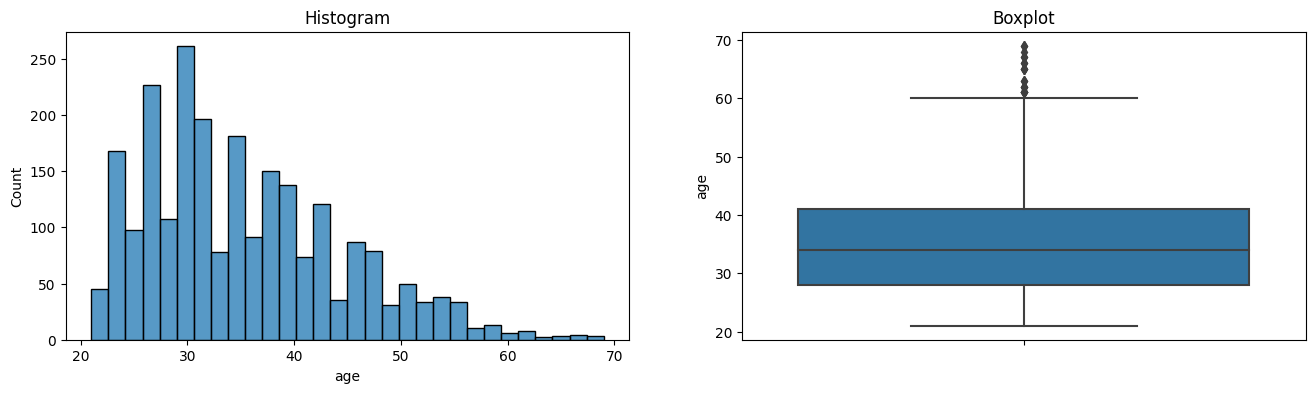

In [157]:
# Lets look at the number and percentage of age

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 80   : {}'.format(len(x_train[x_train['age'] > upper_boundary_distance])))
print('')
print('% distance more than 80: {}'.format(len(x_train[x_train['age'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['age'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'age')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'age')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [158]:
# Identify outliers in `bill_amt_1` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'bill_amt_1', 3)
upper_boundary_distance, lower_boundary_distance

(259550.25, -187622.0)

Total distance : 2372
Distance more than 259550   : 60

% distance more than 259550: 2.5295109612141653
distance - Before Capping


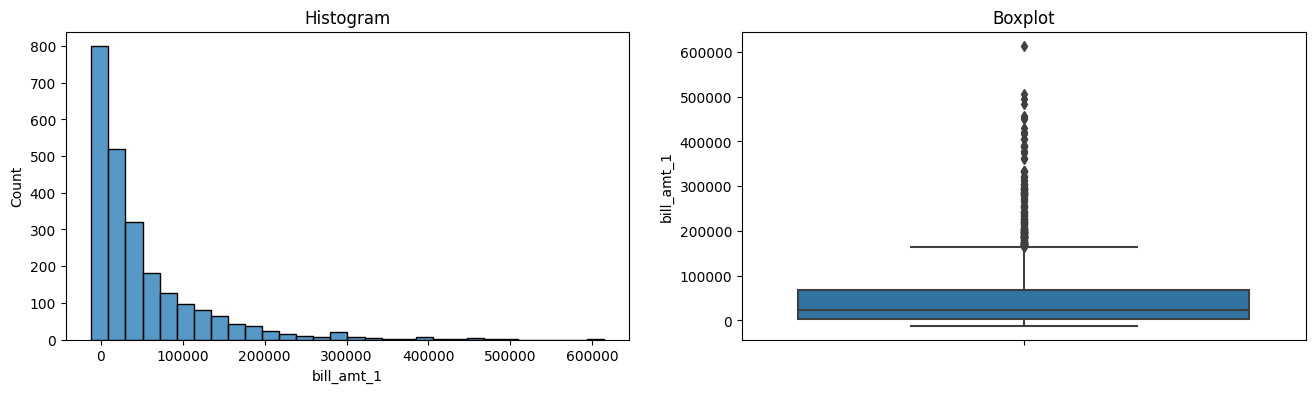


distance - After Capping


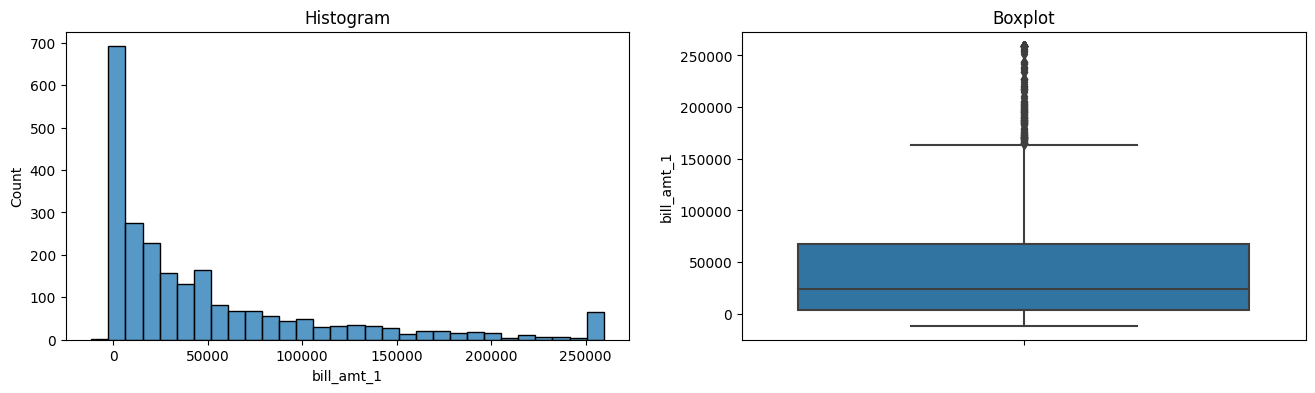

In [159]:
# Lets look at the number and percentage of bill_amt_1

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 259550   : {}'.format(len(x_train[x_train['bill_amt_1'] > upper_boundary_distance])))
print('')
print('% distance more than 259550: {}'.format(len(x_train[x_train['bill_amt_1'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['bill_amt_1'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'bill_amt_1')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'bill_amt_1')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [160]:
# Identify outliers in `bill_amt_2` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'bill_amt_2', 3)
upper_boundary_distance, lower_boundary_distance

(249162.5, -180826.5)

Total distance : 2372
Distance more than 249.162   : 59

% distance more than 249.162: 2.4873524451939293
distance - Before Capping


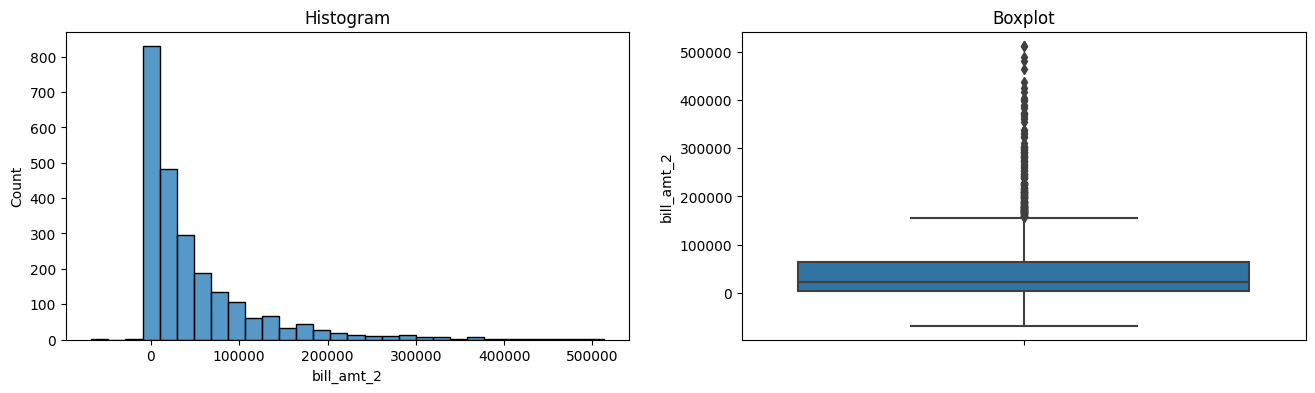


distance - After Capping


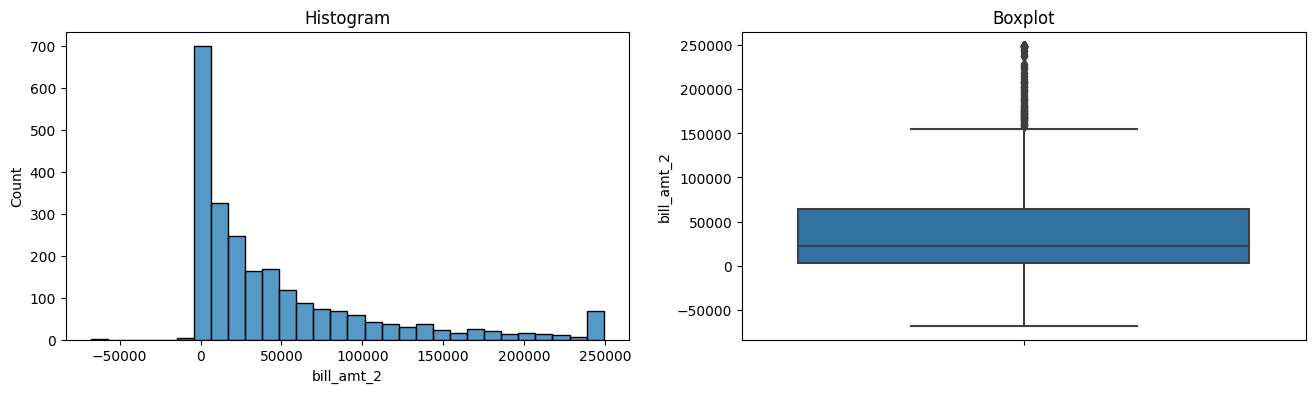

In [161]:
# Lets look at the number and percentage of bill_amt_2

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 249.162   : {}'.format(len(x_train[x_train['bill_amt_2'] > upper_boundary_distance])))
print('')
print('% distance more than 249.162: {}'.format(len(x_train[x_train['bill_amt_2'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['bill_amt_2'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'bill_amt_2')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'bill_amt_2')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [162]:
# Identify outliers in `bill_amt_3` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'bill_amt_3', 3)
upper_boundary_distance, lower_boundary_distance

(235301.75, -170759.5)

Total distance : 2372
Distance more than 235.301   : 61

% distance more than 235.301: 2.5716694772344013
distance - Before Capping


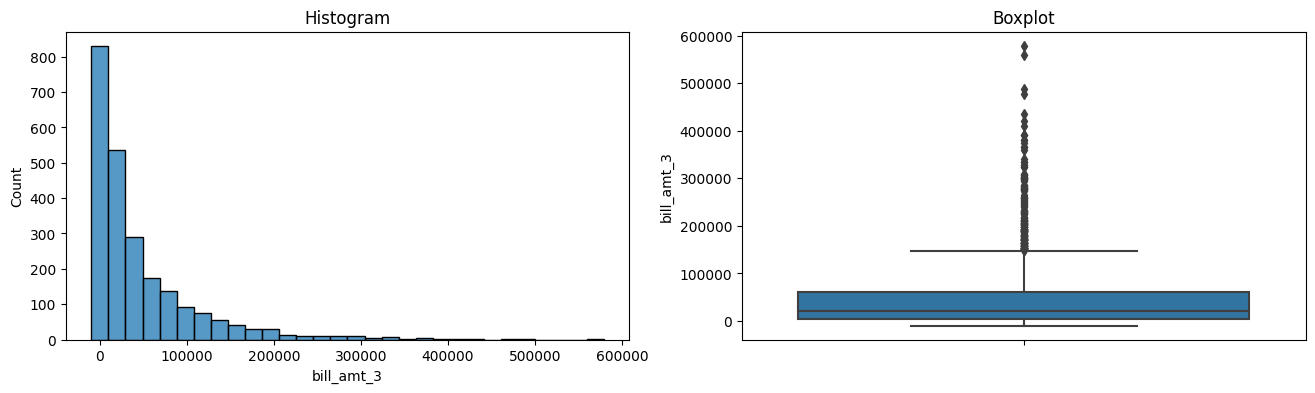


distance - After Capping


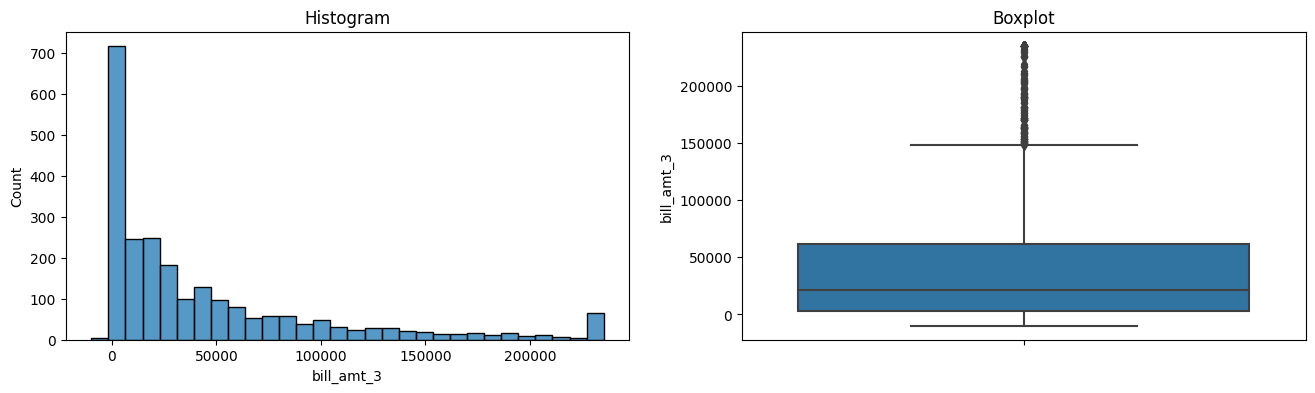

In [163]:
# Lets look at the number and percentage of bill_amt_3

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 235.301   : {}'.format(len(x_train[x_train['bill_amt_3'] > upper_boundary_distance])))
print('')
print('% distance more than 235.301: {}'.format(len(x_train[x_train['bill_amt_3'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['bill_amt_3'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'bill_amt_3')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'bill_amt_3')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [164]:
# Identify outliers in `bill_amt_4` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'bill_amt_4', 3)
upper_boundary_distance, lower_boundary_distance

(222991.0, -162765.0)

Total distance : 2372
Distance more than 222.991   : 55

% distance more than 222.991: 2.318718381112985
distance - Before Capping


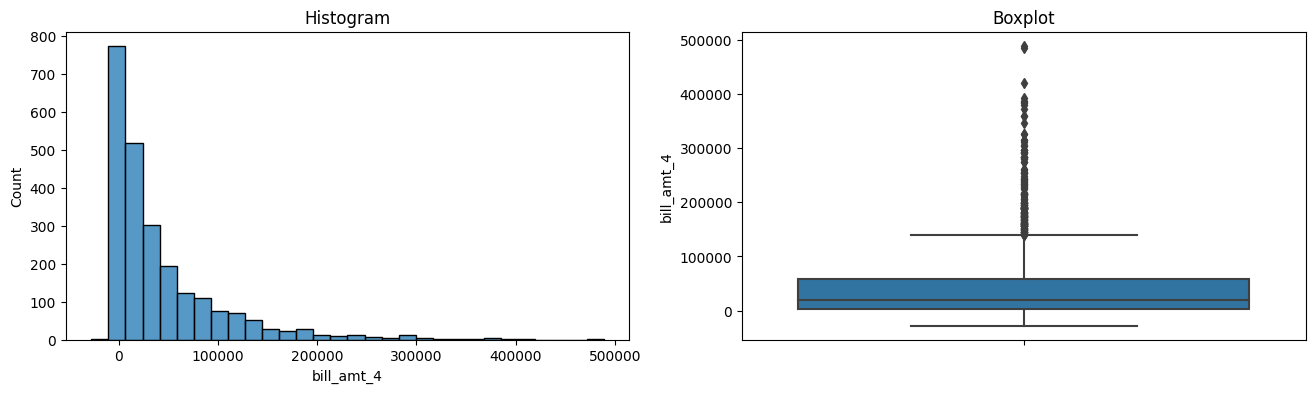


distance - After Capping


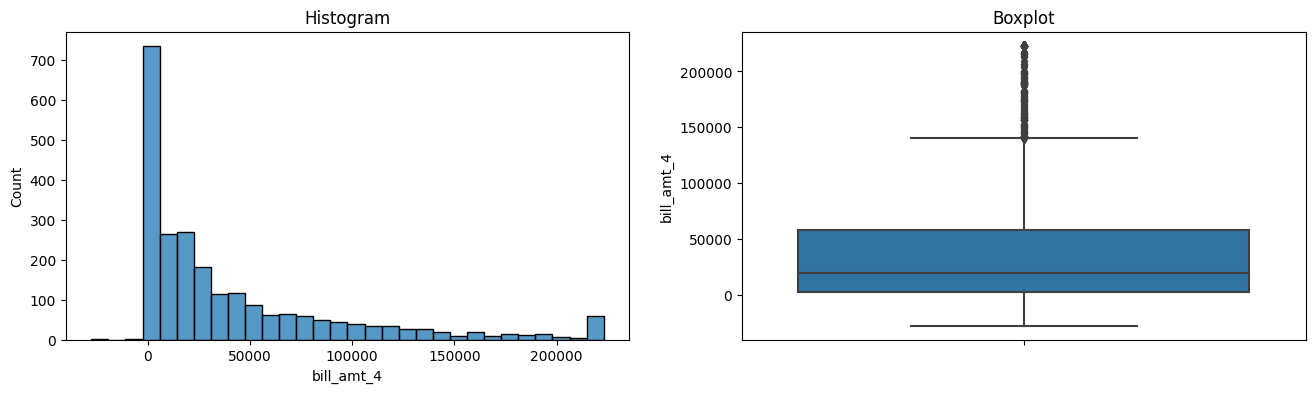

In [165]:
# Lets look at the number and percentage of bill_amt_4

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 222.991   : {}'.format(len(x_train[x_train['bill_amt_4'] > upper_boundary_distance])))
print('')
print('% distance more than 222.991: {}'.format(len(x_train[x_train['bill_amt_4'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['bill_amt_4'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'bill_amt_4')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'bill_amt_4')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [166]:
# Identify outliers in `bill_amt_5` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'bill_amt_5', 3)
upper_boundary_distance, lower_boundary_distance

(198155.25, -145490.5)

Total distance : 2372
Distance more than 198155   : 61

% distance more than 198155: 2.5716694772344013
distance - Before Capping


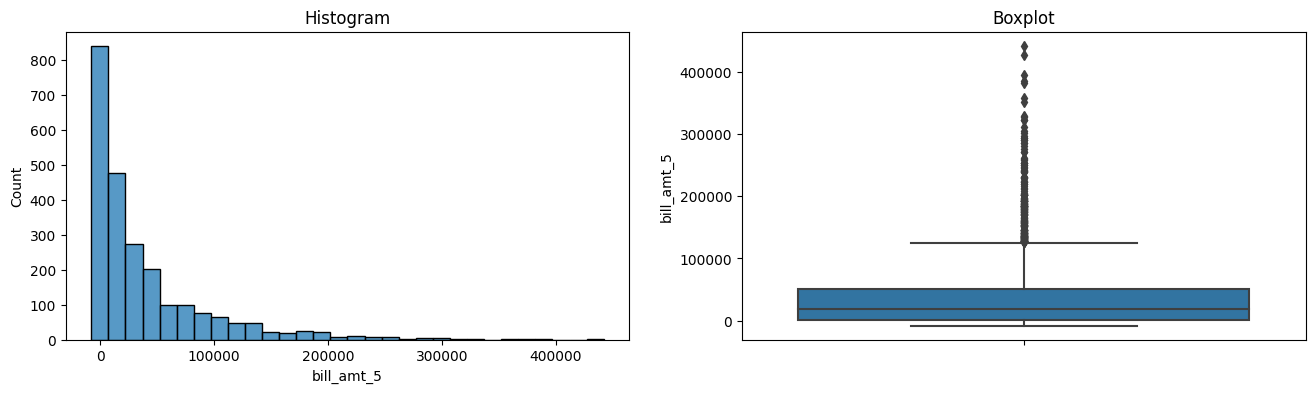


distance - After Capping


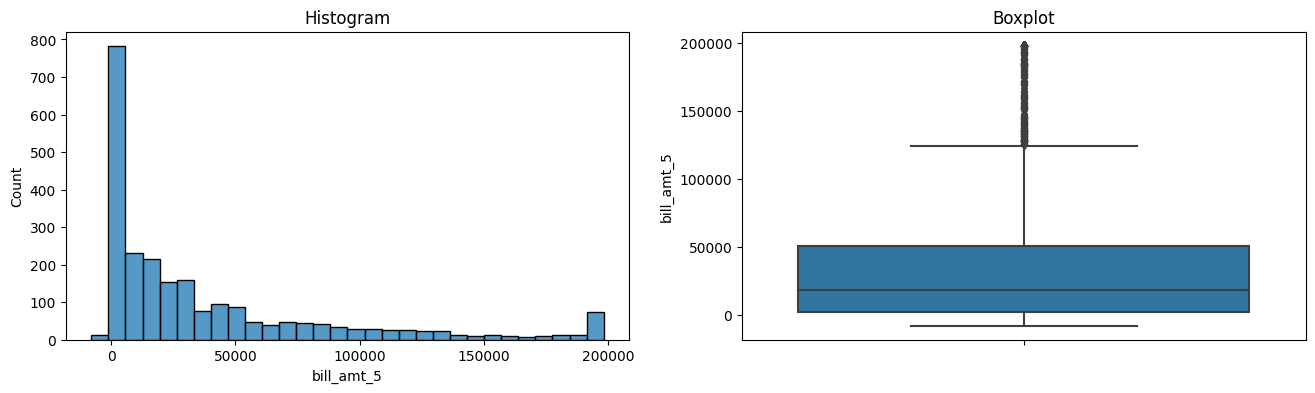

In [167]:
# Lets look at the number and percentage of bill_amt_5

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 198155   : {}'.format(len(x_train[x_train['bill_amt_5'] > upper_boundary_distance])))
print('')
print('% distance more than 198155: {}'.format(len(x_train[x_train['bill_amt_5'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['bill_amt_5'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'bill_amt_5')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'bill_amt_5')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [168]:
# Identify outliers in `bill_amt_6` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'bill_amt_6', 3)
upper_boundary_distance, lower_boundary_distance

(199307.0, -147119.5)

Total distance : 2372
Distance more than 199.307   : 55

% distance more than 199.307: 2.318718381112985
distance - Before Capping


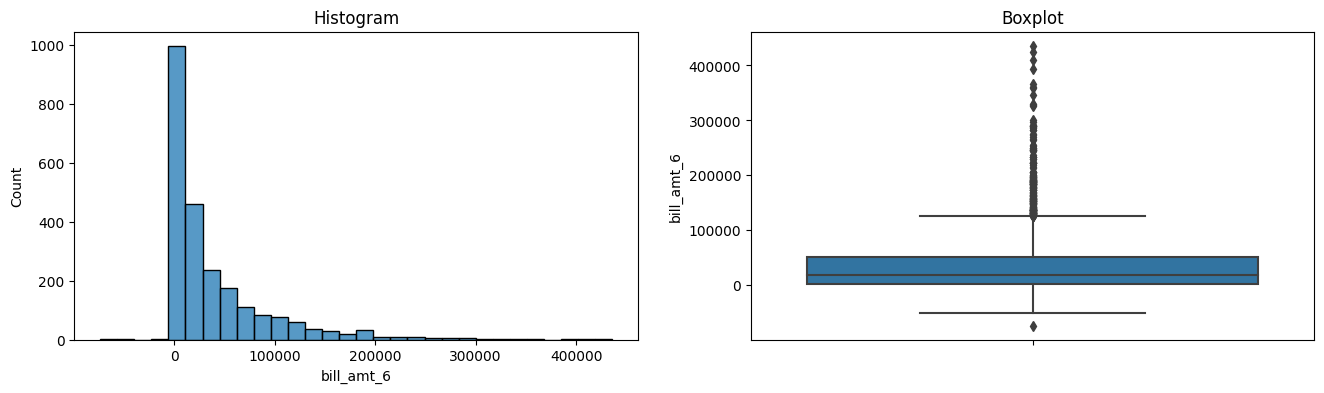


distance - After Capping


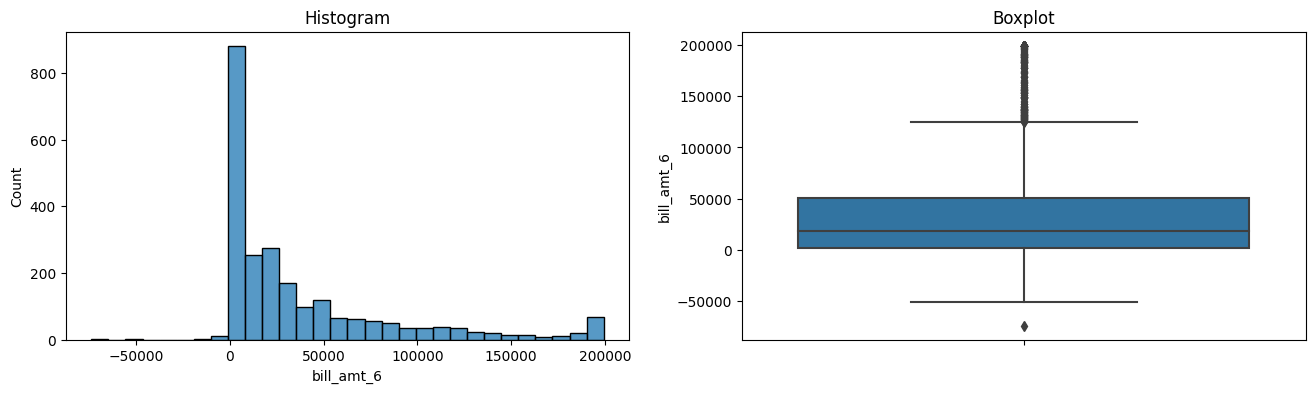

In [169]:
# Lets look at the number and percentage of bill_amt_6

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 199.307   : {}'.format(len(x_train[x_train['bill_amt_6'] > upper_boundary_distance])))
print('')
print('% distance more than 199.307: {}'.format(len(x_train[x_train['bill_amt_6'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['bill_amt_6'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'bill_amt_6')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'bill_amt_6')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [170]:
# Identify outliers in `pay_amt_1` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'pay_amt_1', 3)
upper_boundary_distance, lower_boundary_distance

(17089.25, -11045.5)

Total distance : 2372
Distance more than 17089   : 128

% distance more than 17089: 5.396290050590219
distance - Before Capping


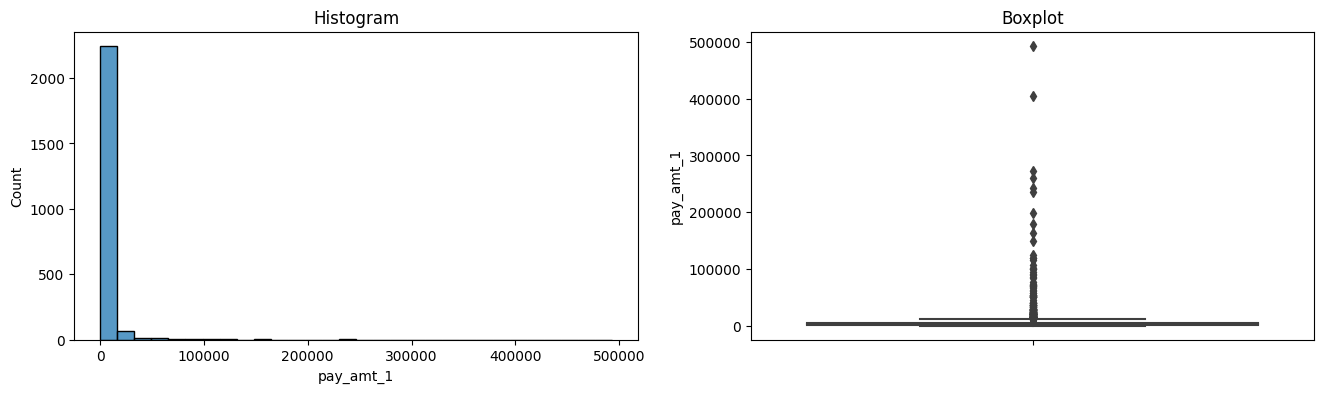


distance - After Capping


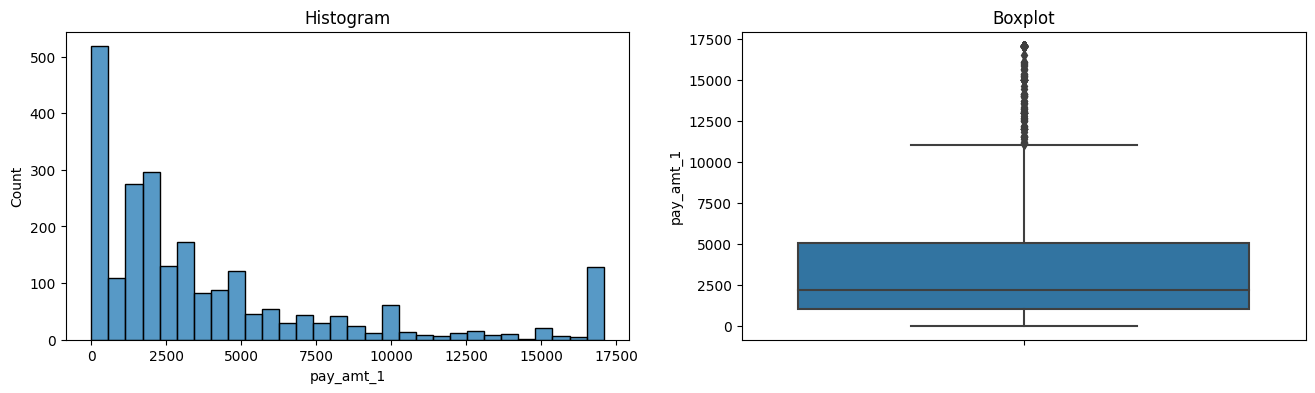

In [171]:
# Lets look at the number and percentage of pay_amt_1

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 17089   : {}'.format(len(x_train[x_train['pay_amt_1'] > upper_boundary_distance])))
print('')
print('% distance more than 17089: {}'.format(len(x_train[x_train['pay_amt_1'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['pay_amt_1'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'pay_amt_1')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'pay_amt_1')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [172]:
# Identify outliers in `pay_amt_2` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'pay_amt_2', 3)
upper_boundary_distance, lower_boundary_distance

(17315.0, -11420.0)

Total distance : 2372
Distance more than 17315   : 127

% distance more than 17315: 5.354131534569983
distance - Before Capping


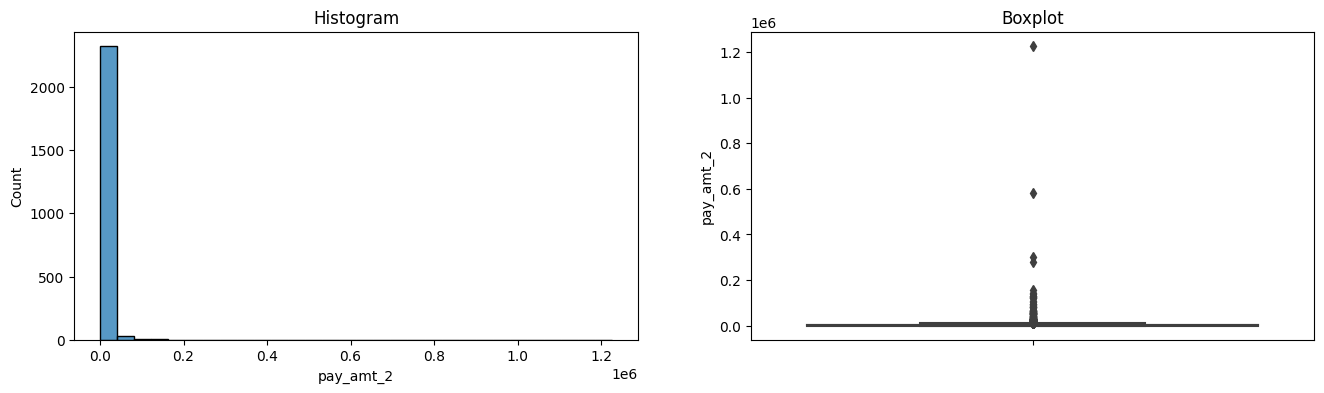


distance - After Capping


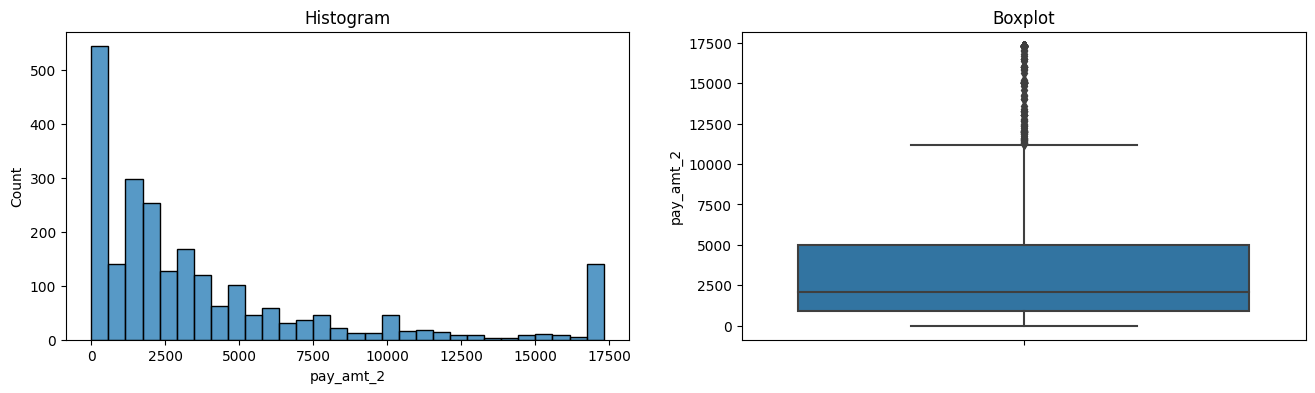

In [173]:
# Lets look at the number and percentage of pay_amt_2

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 17315   : {}'.format(len(x_train[x_train['pay_amt_1'] > upper_boundary_distance])))
print('')
print('% distance more than 17315: {}'.format(len(x_train[x_train['pay_amt_1'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['pay_amt_2'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'pay_amt_2')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'pay_amt_2')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [174]:
# Identify outliers in `pay_amt_3` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'pay_amt_3', 3)
upper_boundary_distance, lower_boundary_distance

(16662.75, -11717.0)

Total distance : 2372
Distance more than 16662   : 125

% distance more than 16662: 5.269814502529511
distance - Before Capping


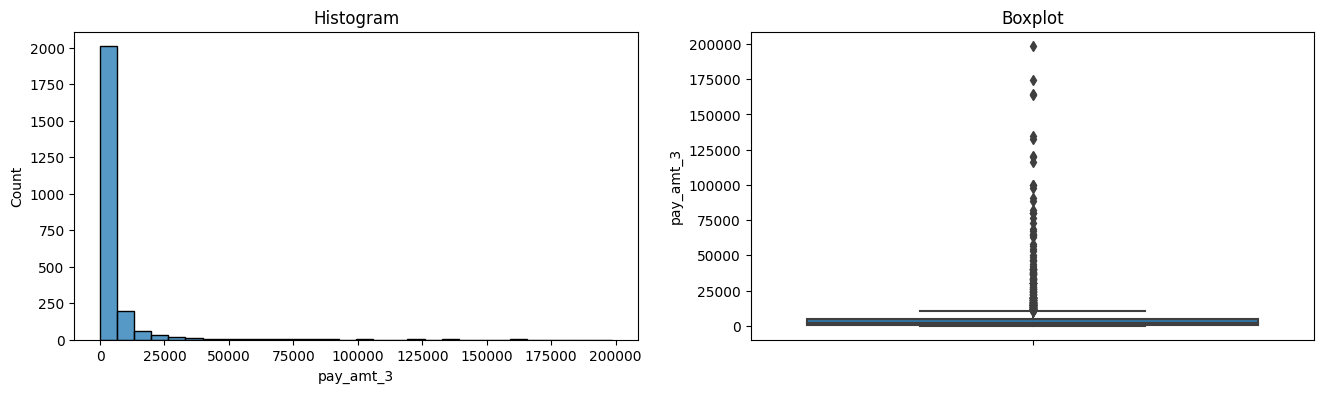


distance - After Capping


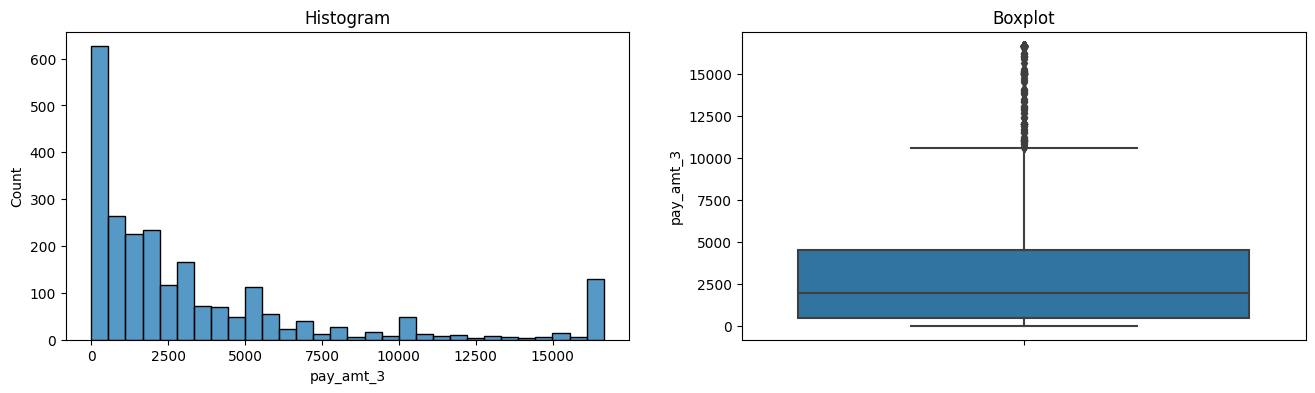

In [175]:
# Lets look at the number and percentage of pay_amt_3

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 16662   : {}'.format(len(x_train[x_train['pay_amt_3'] > upper_boundary_distance])))
print('')
print('% distance more than 16662: {}'.format(len(x_train[x_train['pay_amt_3'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['pay_amt_3'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'pay_amt_3')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'pay_amt_3')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [176]:
# Identify outliers in `pay_amt_4` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'pay_amt_4', 3)
upper_boundary_distance, lower_boundary_distance

(15262.0, -11016.0)

Total distance : 2372
Distance more than 15262   : 98

% distance more than 15262: 4.1315345699831365
distance - Before Capping


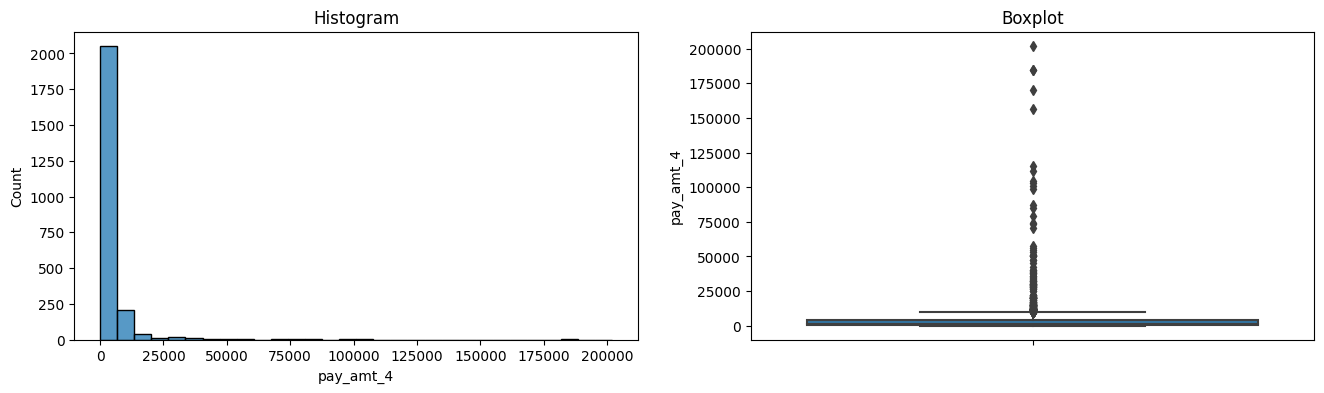


distance - After Capping


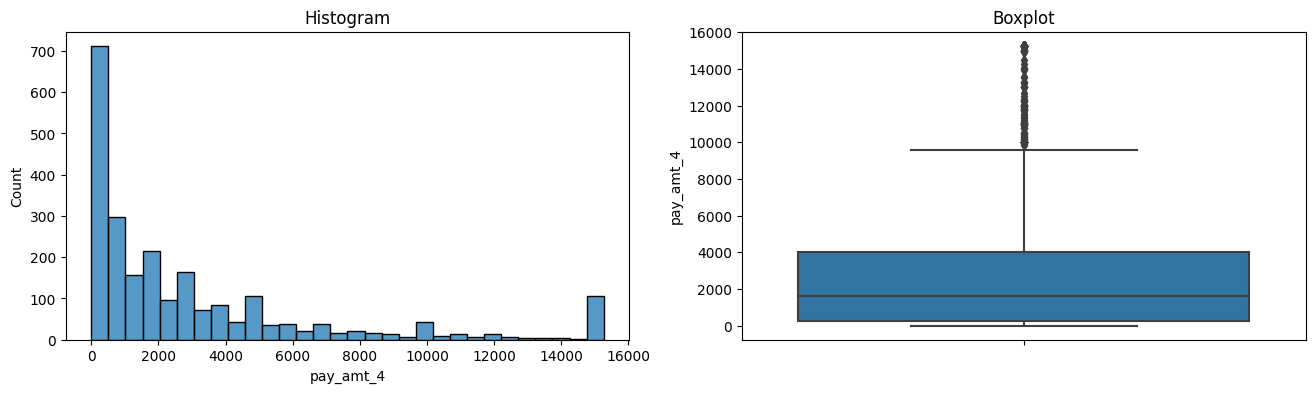

In [177]:
# Lets look at the number and percentage of pay_amt_4

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 15262   : {}'.format(len(x_train[x_train['pay_amt_4'] > upper_boundary_distance])))
print('')
print('% distance more than 15262: {}'.format(len(x_train[x_train['pay_amt_4'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['pay_amt_4'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'pay_amt_4')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'pay_amt_4')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [178]:
# Identify outliers in `pay_amt_5` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'pay_amt_5', 3)
upper_boundary_distance, lower_boundary_distance

(15013.0, -10684.0)

Total distance : 2372
Distance more than 15013   : 123

% distance more than 15013: 5.185497470489039
distance - Before Capping


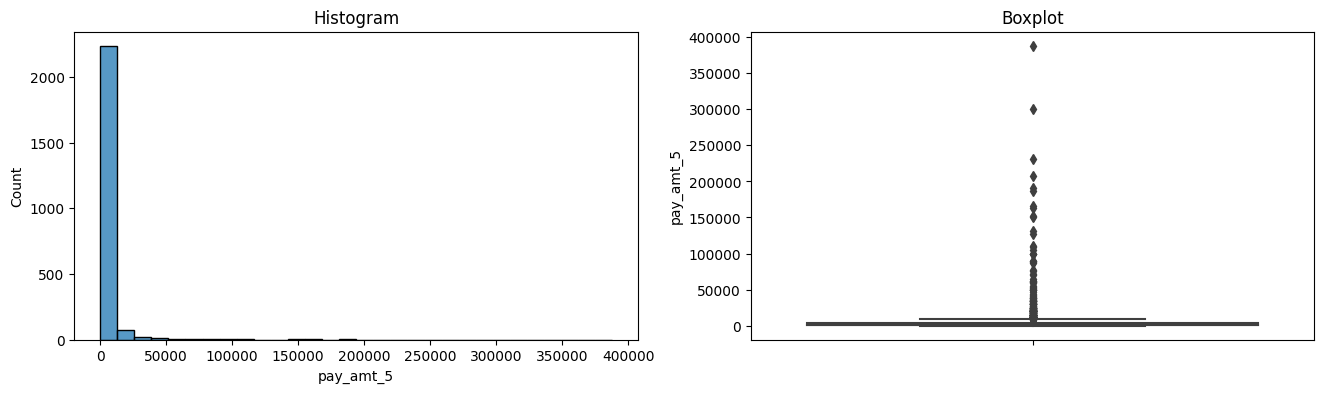


distance - After Capping


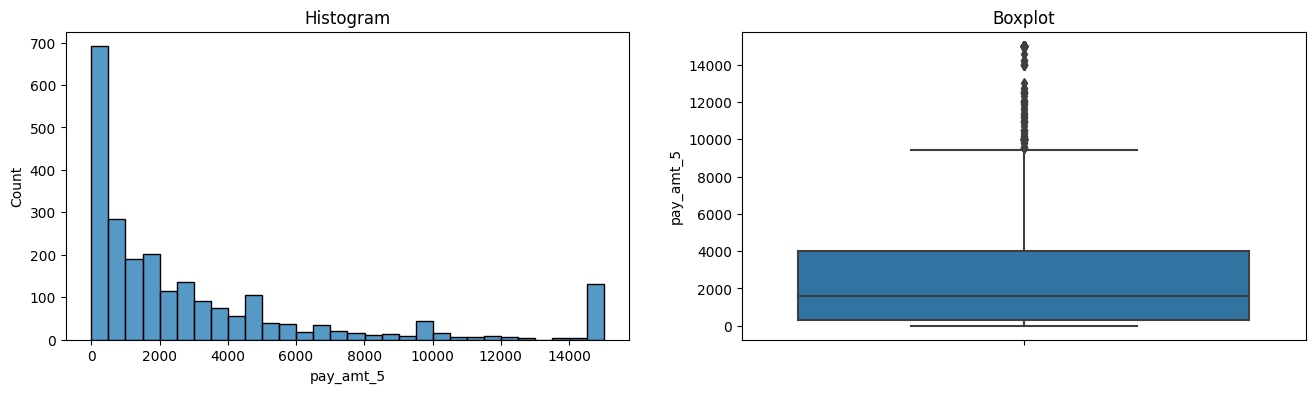

In [179]:
# Lets look at the number and percentage of pay_amt_5

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 15013   : {}'.format(len(x_train[x_train['pay_amt_5'] > upper_boundary_distance])))
print('')
print('% distance more than 15013: {}'.format(len(x_train[x_train['pay_amt_5'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['pay_amt_5'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'pay_amt_5')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'pay_amt_5')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

In [180]:
# Identify outliers in `pay_amt_6` in the credit dataset. Lets look again for extreme values using IQR * 3

upper_boundary_distance, lower_boundary_distance = find_skewed_boundaries(x_train, 'pay_amt_6', 3)
upper_boundary_distance, lower_boundary_distance

(15634.75, -11513.0)

Total distance : 2372
Distance more than 15634   : 138

% distance more than 15634: 5.81787521079258
distance - Before Capping


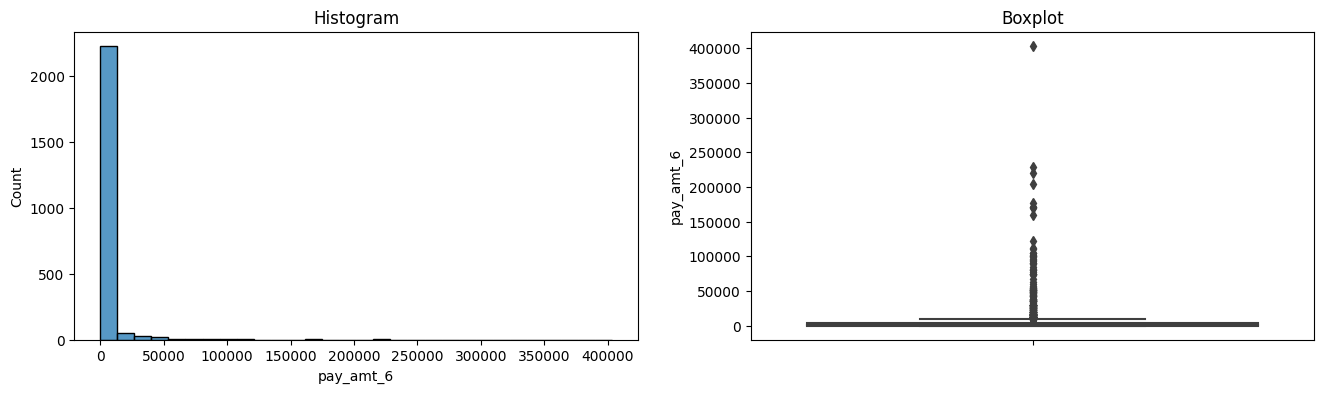


distance - After Capping


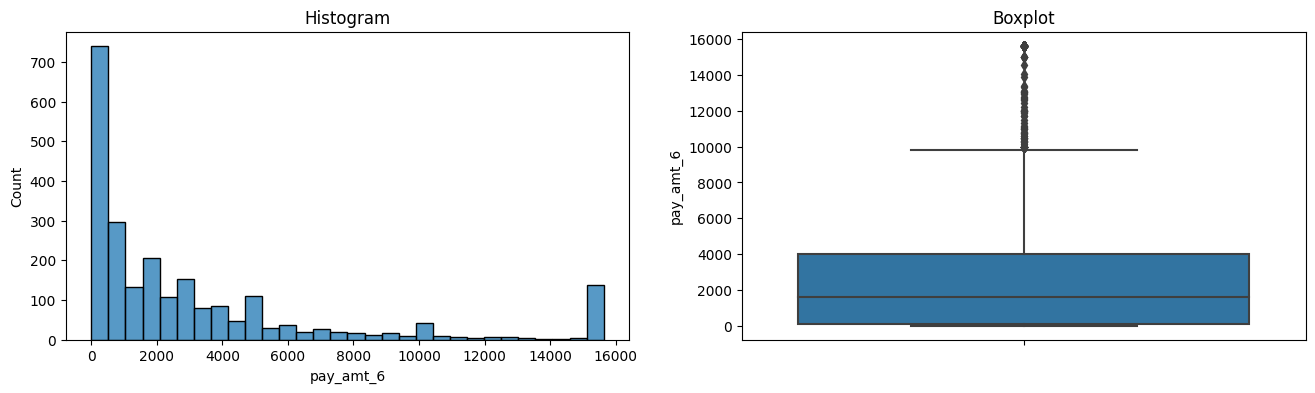

In [181]:
# Lets look at the number and percentage of pay_amt_6

print('Total distance : {}'.format(len(x_train)))
print('Distance more than 15634   : {}'.format(len(x_train[x_train['pay_amt_6'] > upper_boundary_distance])))
print('')
print('% distance more than 15634: {}'.format(len(x_train[x_train['pay_amt_6'] > upper_boundary_distance])/len(x_train) * 100))

# Capping the skewed distribution
winsoriser_distance = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['pay_amt_6'])

x_train_capped = winsoriser_distance.fit_transform(x_train)
x_test_capped = winsoriser_distance.transform(x_test)

# Check the distribution before and after capping

print('distance - Before Capping')
diagnostic_plots(x_train, 'pay_amt_6')

print('\ndistance - After Capping')
diagnostic_plots(x_train_capped, 'pay_amt_6')

Adanya pergeseran outlier,kemungkinan outlier sudah terhandling outliers.

## Handling Missing Value

Jenis handling yang akan dilakukan
1. Pada data x handling bisa dilakukan dengan drop dan imputasi, tetapi jika data termasuk data kategorik tidak bisa memakai mean dan median data sehingga diganti dengan menggunakan modus data, cth data kolom warna.
2. Data y pada missing value hanya bisa dilakukan drop data.

In [182]:
x_train_capped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2372 entries, 118 to 1231
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   limit_balance    2372 non-null   float64
 1   sex              2372 non-null   Int64  
 2   education_level  2372 non-null   Int64  
 3   marital_status   2372 non-null   Int64  
 4   age              2372 non-null   float64
 5   pay_0            2372 non-null   float64
 6   pay_2            2372 non-null   float64
 7   pay_3            2372 non-null   float64
 8   pay_4            2372 non-null   float64
 9   pay_5            2372 non-null   float64
 10  pay_6            2372 non-null   float64
 11  bill_amt_1       2372 non-null   float64
 12  bill_amt_2       2372 non-null   float64
 13  bill_amt_3       2372 non-null   float64
 14  bill_amt_4       2372 non-null   float64
 15  bill_amt_5       2372 non-null   float64
 16  bill_amt_6       2372 non-null   float64
 17  pay_amt_1   

In [183]:
#menampilkan data null pada data x
x_test_capped.isnull().sum()
x_train_capped.isnull().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

Pada data x test dan x train tidak terdapat missing value/ data null, sehingga tidak diperlukan handling missing value

In [184]:
# Check How Many Missing Values in Variable `Y_train` Only
y_test.isnull().sum()
y_train.isnull().sum()

default_payment_next_month    0
dtype: int64

Pada data y tidak terdapat missing value/ data null, sehingga tidak diperlukan handling missing value

## Feauture Selection

Mencari Korelasi data numerik dan data numerik menggunakan uji Pearson

In [185]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['sex'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: -0.01, p-value: 0.7266484096083002


In [186]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['education_level'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.05, p-value: 0.014544578875199431


In [187]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['age'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.04, p-value: 0.05571762344858571


In [188]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['marital_status'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: -0.03, p-value: 0.09689493360386967


In [189]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['limit_balance'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: -0.16, p-value: 2.0510264591340133e-14


In [190]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['pay_0'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.35, p-value: 1.0232203171679143e-69


In [191]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['pay_2'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.28, p-value: 1.468783911624922e-45


In [192]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['pay_3'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.27, p-value: 2.3929965120623826e-42


In [193]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['pay_4'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.26, p-value: 1.0696775063498596e-37


In [194]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['pay_5'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.26, p-value: 9.700419813763505e-37


In [195]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['pay_6'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.23, p-value: 1.011962461182103e-29


In [196]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['bill_amt_1'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.00, p-value: 0.9004053883328532


In [197]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['bill_amt_2'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.01, p-value: 0.5348524103361508


In [198]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['bill_amt_3'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.01, p-value: 0.5457889021822001


In [199]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['bill_amt_4'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.01, p-value: 0.7670622181632867


In [200]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['bill_amt_5'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.02, p-value: 0.33702685969274665


In [201]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['bill_amt_6'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: 0.01, p-value: 0.47308553070993636


In [202]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['pay_amt_1'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: -0.06, p-value: 0.004588686802915128


In [203]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['pay_amt_2'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: -0.06, p-value: 0.006940815904987172


In [204]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['pay_amt_3'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: -0.09, p-value: 1.135702374492126e-05


In [205]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['pay_amt_4'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: -0.06, p-value: 0.004761348301841343


In [206]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['pay_amt_5'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: -0.07, p-value: 0.0009052625064768067


In [207]:
#korelasi antara xtrain dan ytrain
corr_r, pval_p = stats.pearsonr(x_train_capped['pay_amt_6'],y_train['default_payment_next_month'])
print(f"r-correlation: {corr_r:.2f}, p-value: {pval_p}")

r-correlation: -0.11, p-value: 2.8906406488031163e-08


P value disini berguna untuk mengetahui apakah korelasinya nyata atau tidak, jika p value > 0.05 maka korelasinya nyata ,jika korelasinya kurang maka terjadi secara kebetulan.
Untuk nilai Pearson berguna untuk mengukur tingkat korelasi, nilai bisa dari 0-1, semakin dekat ke 0, artinya rendah ,semakin ke arah 1 maka semakin tinggi.

Dari hasil Uji Pearson yang telah dilakukan didapatkan beberapa feauture yang memiliki korelasi yang rendah sehingga dilakukan dropping pada kolom tersebut yaitu sex, marital status, dan age.

Tetapi pada kolom dengan nilai R yang rendah tetap dipakai karena untuk kebutuhan dari segi business knowledge karena dasar dari perhitungan jejak user terhadap history belanja dan pembayaran yang sudah dilakukan: limit balance,pay_amt1, pay_amt2, pay_amt3,pay_amt4, pay_amt5, pay_amt6,bill_amt_1, serta seluruh kolom kecuali 3 kolom yang didropping.

## Scaling

Scaling dilakukan hanya pada data numerik

Pada hasil skew yang sudah didapatkan dibagi lagi dengan ketentuan:
1. Jika skew -0,5< skew < 0,5 termasuk normal sehingga menggunakan standar scaler
2. Jika nilai skew (>0.5 /<-0,5) maka menggunakan minmax scaler
3. Jika nilai skew termasuk extrem skew dengan nilai >1/<-1 digunakan robust scaler

In [208]:
x_train_capped

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
118,300000.0,1,1,2,25.0,0.0,0.0,0.0,0.0,0.0,...,31180.0,19507.0,18169.0,18533.0,4103.0,1427.0,600.0,1200.0,2500.0,15634.75
794,160000.0,2,2,1,35.0,0.0,0.0,0.0,0.0,0.0,...,7035.0,4596.0,4635.0,2744.0,2000.0,1000.0,500.0,1000.0,1000.0,2000.00
1493,130000.0,2,3,1,44.0,-1.0,2.0,2.0,-1.0,0.0,...,0.0,632.0,316.0,316.0,0.0,0.0,948.0,0.0,316.0,316.00
647,30000.0,2,2,1,27.0,0.0,0.0,0.0,0.0,0.0,...,22844.0,22101.0,19535.0,19580.0,1712.0,1400.0,442.0,391.0,500.0,0.00
2469,500000.0,1,1,2,43.0,0.0,0.0,0.0,-1.0,-1.0,...,0.0,3887.0,0.0,7413.0,22650.0,0.0,3887.0,0.0,7413.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,340000.0,2,2,2,27.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,4794.0,7819.0,332.0,16516.0,9318.0,5343.0,7819.0,332.0,16516.0,5000.00
48,310000.0,1,1,2,45.0,0.0,0.0,0.0,0.0,0.0,...,283847.0,290135.0,293350.0,300623.0,10010.0,11500.0,11015.0,11000.0,12000.0,15634.75
772,120000.0,2,2,2,27.0,0.0,0.0,0.0,0.0,0.0,...,9624.0,20129.0,10388.0,13316.0,1137.0,1514.0,1069.0,278.0,3000.0,0.00
1848,60000.0,2,2,1,31.0,0.0,0.0,2.0,2.0,2.0,...,39676.0,42407.0,41428.0,45576.0,4000.0,0.0,3700.0,0.0,5000.0,2000.00


In [209]:
#handling menggunakan minmaxscaler
minmaxscale=MinMaxScaler()
minmaxscale.fit(x_train_capped[['education_level','pay_2']])

x_train_scale2= minmaxscale.transform(x_train_capped[['education_level','pay_2']])
x_test_scale2= minmaxscale.transform(x_test_capped[['education_level','pay_2']])

In [210]:
#handling menggunakan robustscaler
robscale=RobustScaler()
robscale.fit(x_train_capped[['limit_balance','pay_0','pay_3','pay_4','pay_5','pay_6',
'bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6',
'pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6']])

x_train_scale3= robscale.transform(x_train_capped[['limit_balance','pay_0','pay_3','pay_4','pay_5','pay_6',
'bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6',
'pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6']])
x_test_scale3= robscale.transform(x_test_capped[['limit_balance','pay_0','pay_3','pay_4','pay_5','pay_6',
'bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6',
'pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6']])

## Encoding

Encoding dilakukan pada data kategorik

Jadi,
1. Apabila data kategorik-nominal maka menggunakan onehot encoder
2. sedangkan data kategorik ordinal menggunakan Ordinal encoder
3. Pada data target/ y yang memiliki data text akan diubah menjadi data angka menggunakan label encoder

Karena tidak adanya data kategorik maka proses Encoding tidak dilakukan

## Concate Data

In [211]:
# concate data
x_train_final = np.concatenate([x_train_scale2,x_train_scale3], axis=1)
x_test_final = np.concatenate([x_test_scale2,x_test_scale3], axis=1)
pd.DataFrame(x_train_final)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.166667,0.222222,0.888889,0.0,0.0,0.0,0.0,0.0,0.827310,0.308456,0.167587,-0.001071,-0.008331,0.006537,0.473471,-0.163946,-0.330394,-0.106153,0.245165,3.618836
1,0.333333,0.222222,0.111111,0.0,0.0,0.0,0.0,0.0,-0.099027,-0.160947,-0.248644,-0.271648,-0.284016,-0.312501,-0.049761,-0.267966,-0.355060,-0.159430,-0.163443,0.103139
2,0.500000,0.444444,-0.055556,-1.0,2.0,-1.0,0.0,-1.0,-0.366865,-0.366443,-0.369918,-0.343580,-0.371994,-0.361562,-0.547366,-0.511571,-0.244558,-0.425812,-0.349768,-0.331077
3,0.333333,0.222222,-0.611111,0.0,0.0,0.0,0.0,0.0,-0.014621,0.007757,0.023884,0.046001,0.019494,0.027693,-0.121416,-0.170524,-0.369365,-0.321657,-0.299646,-0.412557
4,0.166667,0.222222,2.000000,0.0,0.0,-1.0,-1.0,-1.0,7.522900,7.974091,-0.369918,-0.284514,-0.378430,-0.218157,5.088014,-0.511571,0.480360,-0.425812,1.583492,-0.412557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2367,0.333333,0.111111,1.111111,-1.0,-1.0,-1.0,-1.0,-1.0,-0.145942,-0.219895,-0.287276,-0.213163,-0.371668,-0.034219,1.770977,0.790012,1.450207,-0.337373,4.063198,0.876684
2368,0.166667,0.222222,0.944444,0.0,0.0,0.0,0.0,0.0,4.527115,4.167475,4.523257,4.909795,5.597055,5.706534,1.943149,2.289890,2.238515,2.504395,2.833016,3.618836
2369,0.333333,0.222222,-0.111111,0.0,0.0,0.0,0.0,0.0,-0.138287,-0.237330,-0.204012,0.010216,-0.166829,-0.098880,-0.264477,-0.142753,-0.214713,-0.351758,0.381367,-0.412557
2370,0.333333,0.222222,-0.444444,0.0,2.0,2.0,2.0,2.0,0.211031,0.289409,0.314047,0.414477,0.465450,0.552976,0.447845,-0.511571,0.434236,-0.425812,0.926178,0.103139


# Model Definition

In [212]:
#pembuatan model dengan logistic regresi
model_logreg = LogisticRegression(penalty='l2', C=1.0, random_state=0)


In [213]:
#pembuatan model dengan SVM
model_svm = SVC(kernel='linear')

In [214]:
#pembuatan model dengan KNN
knn = KNeighborsClassifier(n_neighbors=3)

# Model Training

In [215]:
#model latih dengan logistic regresi
model_logreg.fit(x_train_final, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

In [216]:
#model latih dengan SVM
%%time
model_svm.fit(x_train_final, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 5.51 s, sys: 27.1 ms, total: 5.53 s
Wall time: 10.8 s


SVC(kernel='linear')

In [217]:
#model latih dengan KNN
knn.fit(x_train_final, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

# Model Evaluation

## Logistic Regresi

In [218]:
#Cek akurasi model logistic regresi

print('Accuracy - Train Set : ', model_logreg.score(x_train_final, y_train))
print('Accuracy - Test Set  : ', model_logreg.score(x_test_final, y_test))

Accuracy - Train Set :  0.8241989881956155
Accuracy - Test Set  :  0.8499156829679595


Model Logistic regresi bisa dikatakan model yang fit untuk dataset ini, dikarenakan nilai akurasi dari data train dan data test diatas 80%.

###Hyperparameter

In [219]:
# Model Prediction

y_pred_train_logreg = model_logreg.predict(x_train_final)
y_pred_test_logreg = model_logreg.predict(x_test_final)

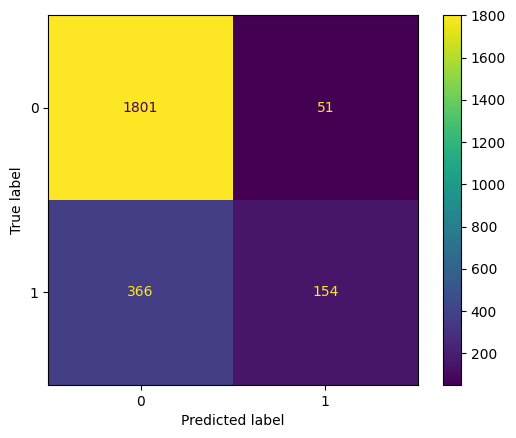

In [220]:
# Confusion Matrix -Data Train
cm_train = confusion_matrix(y_train, y_pred_train_logreg)
ConfusionMatrixDisplay(cm_train).plot()

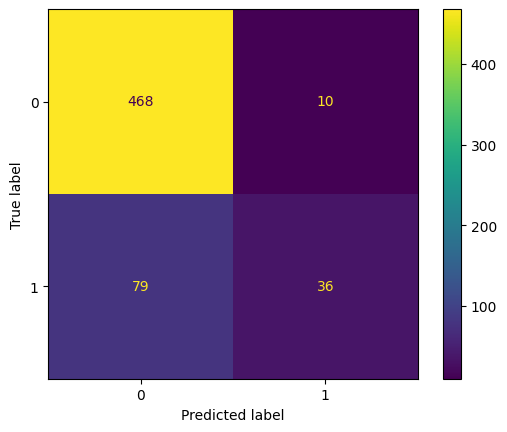

In [221]:
# Confusion Matrix -Data Test
cm_test = confusion_matrix(y_test, y_pred_test_logreg)
ConfusionMatrixDisplay(cm_test).plot()

In [222]:
# Model Evaluation - Train Set

print(classification_report(y_train, y_pred_train_logreg))

              precision    recall  f1-score   support

         0.0       0.83      0.97      0.90      1852
         1.0       0.75      0.30      0.42       520

    accuracy                           0.82      2372
   macro avg       0.79      0.63      0.66      2372
weighted avg       0.81      0.82      0.79      2372



In [223]:
#Model latih dengan Logistic Regression pada default thershold 0.05
print(classification_report(y_test, y_pred_test_logreg))

              precision    recall  f1-score   support

         0.0       0.86      0.98      0.91       478
         1.0       0.78      0.31      0.45       115

    accuracy                           0.85       593
   macro avg       0.82      0.65      0.68       593
weighted avg       0.84      0.85      0.82       593



In [224]:
# Get Precision Score and Recall Score

print('Precision : ', precision_score(y_test, y_pred_test_logreg))
print('Recall    : ', recall_score(y_test, y_pred_test_logreg))

Precision :  0.782608695652174
Recall    :  0.3130434782608696


In [225]:
#Model latih dengan Logistic Regression pada C=0.005
logreg_1 = LogisticRegression(C=0.005, random_state=10)
logreg_1.fit(x_train_final, y_train)

# Model Prediksi
y_pred_train_logreg_5 = logreg_1.predict(x_train_final)
y_pred_test_logreg_5 = logreg_1.predict(x_test_final)

# Model Evaluation - Test Set
print(classification_report(y_test, y_pred_test_logreg_5))
print('Precision : ', precision_score(y_test, y_pred_test_logreg_5))
print('Recall    : ', recall_score(y_test, y_pred_test_logreg_5))

              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90       478
         1.0       0.77      0.17      0.28       115

    accuracy                           0.83       593
   macro avg       0.80      0.58      0.59       593
weighted avg       0.82      0.83      0.78       593



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precision :  0.7692307692307693
Recall    :  0.17391304347826086


Pada hasil hyperparameter dengan menganti nilai c=1 dan c=0,005, maka dari nilai akurasi yang dihasilakn pada dataset ini memiliki nilai yang lebih tinggi pada c=1 dan memiliki nilai fit yang lebih bagus pada c=1.

In [226]:
#nilai fpr,tpr,AUC,ROC
y_pred_proba_logreg_1 = model_logreg.predict_proba(x_test_final)[:, 1]
fpr_logreg_1, tpr_logreg_1, _ = roc_curve(y_test, y_pred_proba_logreg_1)
auc_logreg_1 = roc_auc_score(y_test, y_pred_proba_logreg_1)

print('AUC Score : ', auc_logreg_1)
pd.DataFrame({'FPR': fpr_logreg_1, 'TPR': tpr_logreg_1})

AUC Score :  0.7845006367109333


,FPR,TPR
0,0.000000,0.000000
1,0.002092,0.000000
2,0.002092,0.026087
3,0.008368,0.026087
4,0.008368,0.095652
...,...,...
129,0.968619,0.982609
130,0.968619,0.991304
131,0.983264,0.991304
132,0.983264,1.000000


In [227]:
# Nilai FPR, TPR, dan AUC Score pada Logistic Regression C=0.005
y_pred_proba_logreg_5 = logreg_1.predict_proba(x_test_final)[:, 1]
fpr_logreg_5, tpr_logreg_5, _ = roc_curve(y_test, y_pred_proba_logreg_5)
auc_logreg_5 = roc_auc_score(y_test, y_pred_proba_logreg_5)

print('AUC Score : ', auc_logreg_5)

AUC Score :  0.7915772239403311


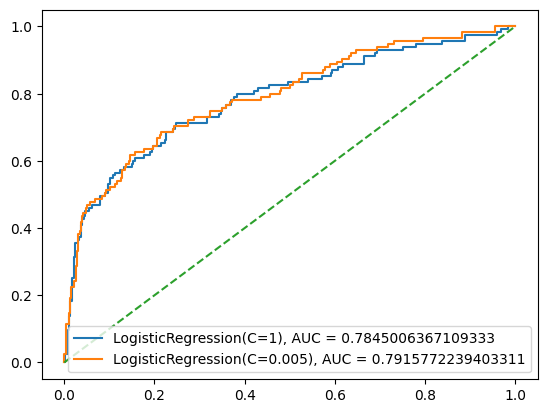

In [228]:
# Plot ROC-AUC Curve

plt.figure(0).clf()
plt.plot(fpr_logreg_1, tpr_logreg_1, label='LogisticRegression(C=1), AUC = ' + str(auc_logreg_1))
plt.plot(fpr_logreg_5, tpr_logreg_5, label='LogisticRegression(C=0.005), AUC = ' + str(auc_logreg_5))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=0)

pada kurva roc-auc , semakin tinggi area dibawah kurva maka semain model dalam memprediksi. Model cukup baik untuk menjelaskan determinan pemakaian kartu kredit dengan kategori fair discrimantion. Model logit/fit untuk mengestimasi parameter.

## SVM

In [229]:
#Evaluasi Model SVM

def performance_check(clf, x, y):
  y_pred = clf.predict(x)
  return f1_score(y, y_pred)

print('Model SVM')
print('Train : ', performance_check(model_svm, x_train_final, y_train))
print('Test  : ', performance_check(model_svm, x_test_final, y_test))

Model SVM
Train :  0.5236363636363637
Test  :  0.5347593582887701


Model SVM bisa disimpulkan **underfit** karena nilai dari hasil nilai perfoma cukup rendah di bawah 80%, sehingga tidak cocok digunakan pada dataset ini.

###Hyperparameter

In [230]:
#pembuatan model dengan SVM kernel RBF
model_svm2 = SVC(kernel='rbf')
model_svm2.fit(x_train_final, y_train)
print('Model SVM RBF')
print('Train : ', performance_check(model_svm2, x_train_final, y_train))
print('Test  : ', performance_check(model_svm2, x_test_final, y_test))


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model SVM RBF
Train :  0.4275862068965517
Test  :  0.389937106918239


Ketika membandingkan dua paramater yang berbeda pada model SVM maka bisa dilihat ketika parameternya diganti kita melihat nilai train dan test menurun pada kernel rbf, sehingga yang akan di pakai pada dataset ini yaitu dengan kernel linear.

## KNN

In [231]:
# Model Prediction

y_pred_train_knn = knn.predict(x_train_final)
y_pred_test_knn = knn.predict(x_test_final)

In [232]:
# Model Evaluation - Train Set & Test Set

print(classification_report(y_train, y_pred_train_knn))
print(classification_report(y_test, y_pred_test_knn))

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      1852
         1.0       0.76      0.57      0.65       520

    accuracy                           0.87      2372
   macro avg       0.82      0.76      0.78      2372
weighted avg       0.86      0.87      0.86      2372

              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87       478
         1.0       0.46      0.41      0.43       115

    accuracy                           0.79       593
   macro avg       0.66      0.65      0.65       593
weighted avg       0.78      0.79      0.79       593



Pada dataset ini dilihat pada nilai akurasi yang cukup jauh yang diartikan underfit pada dataset ini.

### Hyperparameter

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

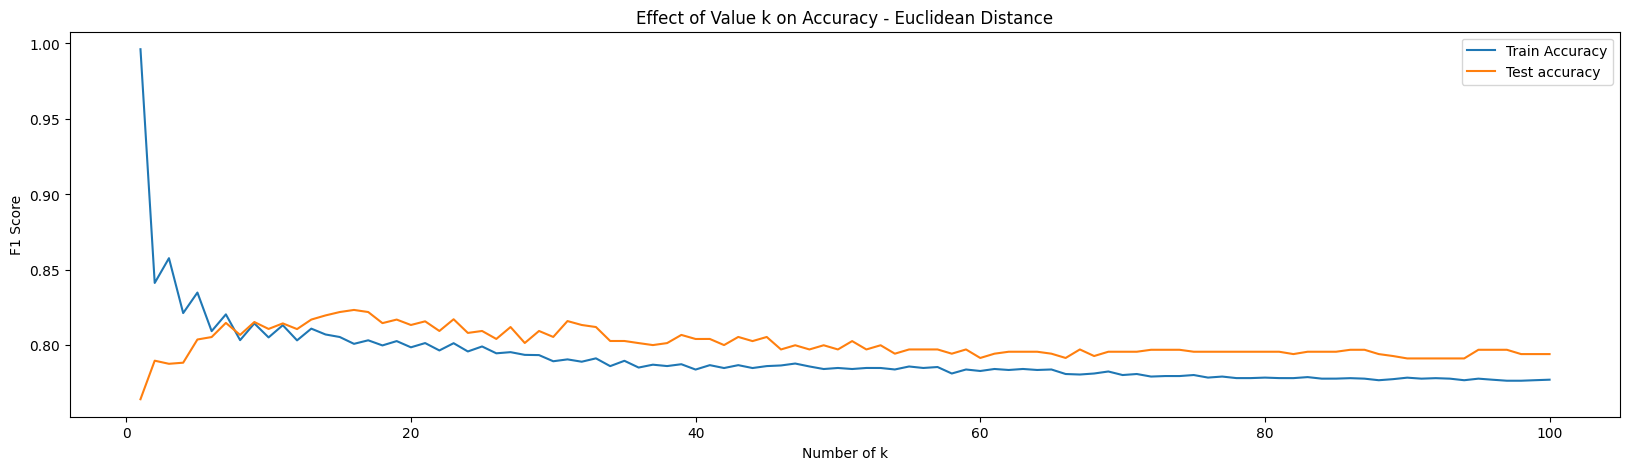

CPU times: user 45.6 s, sys: 504 ms, total: 46.1 s
Wall time: 50.8 s


In [233]:
# Cari nilai F1 Score dari k = 1 sampai k = 15
%%time

max_k = 100

train_acc = []
test_acc = []

for loop in range (1, max_k+1):
  knn = KNeighborsClassifier(n_neighbors = loop)
  knn.fit(x_train_final, y_train)

  y_pred_train_knn = knn.predict(x_train_final)
  y_pred_test_knn = knn.predict(x_test_final)

  train_acc.append(f1_score(y_train, y_pred_train_knn, average='weighted'))
  test_acc.append(f1_score(y_test, y_pred_test_knn, average='weighted'))

# Visualization of Accuracy
plt.figure(figsize=(20,5))
plt.title('Effect of Value k on Accuracy - Euclidean Distance')
plt.plot(range(1, max_k+1), train_acc, label='Train Accuracy')
plt.plot(range(1, max_k+1), test_acc, label='Test accuracy')

plt.legend()
plt.xlabel('Number of k')
plt.ylabel('F1 Score')
plt.show()

Semakin bertambah jumlah neigbour yang digunakan, akan membuat nilai pada model train menurun, sedangakn pada test terjadi peningkatan tetapi diambang nilai tertentu dan jika nilai terus dinaikkan tidak berpengaruh lagi.

In [234]:
#pembuatan model dengan KNN dengan neigbour 11
knn1 = KNeighborsClassifier(n_neighbors=11)
knn1.fit(x_train_final, y_train)
y_pred_train_knn1 = knn1.predict(x_train_final)
y_pred_test_knn1 = knn1.predict(x_test_final)
print(classification_report(y_train, y_pred_train_knn1))
print(classification_report(y_test, y_pred_test_knn1))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90      1852
         1.0       0.74      0.38      0.50       520

    accuracy                           0.83      2372
   macro avg       0.79      0.67      0.70      2372
weighted avg       0.82      0.83      0.81      2372

              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91       478
         1.0       0.69      0.31      0.43       115

    accuracy                           0.84       593
   macro avg       0.77      0.64      0.67       593
weighted avg       0.82      0.84      0.81       593



Pada model KNN dengan n=11 dibandingkan dengan n=3, memiliki nilai yang berbeda. Pada dataset ini kita melihat dari nilai akurasi dari  keseluruhan  dataset yang benar diprediksi yaitu nilai aktual dataset user kartu kredit untuk menghitung ketepatan data. dan yang digunakan yaitu pada n=11.

# Model Saving

> Pada bagian ini, dilakukan proses penyimpanan model dan file-file lain yang terkait dengan hasil proses pembuatan model.

In [235]:
#pembuatan model saving
with open('model_logreg.pkl', 'wb') as file_1:
  pickle.dump(model_logreg, file_1)

with open('model_scalerminmax.pkl', 'wb') as file_4:
  pickle.dump(minmaxscale, file_4)

with open('model_scalerob.pkl', 'wb') as file_5:
  pickle.dump(robscale, file_5)

with open('list_num_cols.txt', 'w') as file_6:
  json.dump(num_columns, file_6)

# Model Inference

In [238]:
#Buat Data Baru
new_data = {
    'education_level': 2,
    'pay_2': 0,
    'limit_balance': 160000,
    'pay_0': -1,
    'pay_3': 0,
    'pay_4': -1,
    'pay_5': 0,
    'pay_6': 0,
    'bill_amt_1': 49221,
    'bill_amt_2': 19420,
    'bill_amt_3': 50942,
    'bill_amt_4': 1434,
    'bill_amt_5': 500,
    'bill_amt_6': 0,
    'pay_amt_1': 7000,
    'pay_amt_2': 1019,
    'pay_amt_3': 900,
    'pay_amt_4': 390,
    'pay_amt_5': 0,
    'pay_amt_6': 0
}
new_data = pd.DataFrame([new_data])

# Feature Scaling
new_data_scaled = minmaxscale.transform(new_data[['education_level','pay_2']])
new_data_scaled1= robscale.transform(new_data[['limit_balance','pay_0','pay_3','pay_4','pay_5','pay_6',
'bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6',
'pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6']])

# Concate Data
data_final = np.concatenate([new_data_scaled,new_data_scaled1], axis=1)
y_pred_train_new = model_logreg.predict(data_final)
y_pred_train_new


array([0.])

# Pengambilan Kesimpulan

1. Berdasarkan hasil EDA, belum ada data yang saling berhubungan jika dilihat dari gambar plot yang dihasilkan masih terlalu acak.

2. Berdasarkan hasil Model Evaluation model yang kita gunakan ada 3 jenis pada dataset ini yaitu ada: logistric regresi, SVM dan KNN.
Logistic regresi memiliki nilai fit di atas 80%
SVM memiliki nilai dibawah 80%
KNN memiliki nilai 80% apda data train tetapi pada data test memiliki nilai dibawah 80% sehingga bisa dikategorikan undefit

Pada dataset ini, model yang sesuai menghasilkan dengan parameter yang digunakan yaitu niali akurasi dengan nilai yang fit/sesuai ada pada model Logistic regresi.

3. Berdasarkan hasil Model Analysis, pengguna kartu kredit sebagian besar berusia 21-68 tahun. Berdasarkan hasil analisis kurva Roc, maka model logit yang terbentuk dapat disimpulkan ke dalam kategori Fair Discrimination, sehingga dapat dikatakan model logit sudah sesuai(fit) untuk mengestimasi parameter.

4. Improvement selanjutnya dari model yang dibuat pada dataset yang lebih luas dan menggunakan model yang berbeda sehingga dapat menyempurnakan hasil yang sudah didapatkan.
